In [8]:
import os
import sys
sys.path.append("../bottlenecks")
import configs
from cbm import *
from data_utils import *
from trainer_utils import *
from graph_plot_tools import *
from utils import *
from metric_utils import *
from peft import LoraConfig, get_peft_model
from typing import List, Dict, Optional
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

In [9]:
configs.set_seed(42)
device = configs.set_device(2)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


In [10]:
torch.cuda.get_device_name(device)

'NVIDIA A100-SXM4-80GB'

In [11]:
plt.style.use("seaborn-v0_8")

In [12]:
with open("../data/cub_filtered.txt", "r") as f:
    concepts = f.read().split('\n')

In [13]:
len(concepts)

370

In [14]:
train_loader_preprocessed  = prepared_dataloaders(Constants.cub200_link,
                                                  concepts=concepts,
                                                  prep_loaders="train",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/74 [00:00<?, ?it/s]

In [15]:
val_loader_preprocessed  = prepared_dataloaders(Constants.cub200_link,
                                                  concepts=concepts,
                                                  prep_loaders="val",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
test_loader_preprocessed  = prepared_dataloaders(Constants.cub200_link,
                                                  concepts=concepts,
                                                  prep_loaders="test",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
config = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=200,
    run_name="cub_interpretation",
    net_types=["base", "base"],
    backbones=[Constants.clip_large_link, Constants.clip_large_link],
    displayed_names=["CLIP L/14, gumbel, 3e-4", "CLIP L/14, contrastive, 3e-4", ],
    training_methods=["gumbel", "contrastive"],
    optimizers=["Adam", "Adam"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
    lora_connections=[],
)

In [18]:
trainer = BottleneckTrainer(
    config,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=10,
    device=device,
    #report_to="wandb",
)

In [19]:
print_trainable_parameters(trainer.nets[0])

trainable params: 210,900 || all params: 427,827,413 || trainable%: 0.05


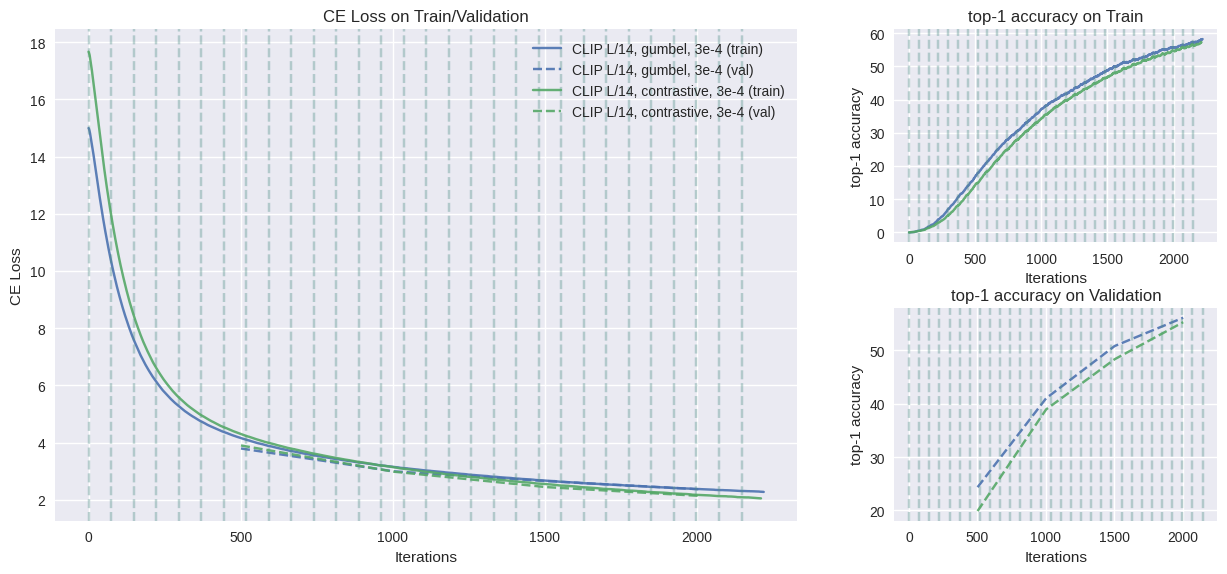

Finished Training


In [22]:
trainer.train()

In [23]:
trainer.test()

Begin Testing


0it [00:00, ?it/s]

57.62442131042481 

58.932291412353514 

Finished Testing


In [29]:
@torch.no_grad()
def draw_confusion_matrix(model, loader, device, save_drawing: bool = False,):
    """
    Draws a confusion matrix for model prediction on the selected dataloader
    If you use this function after training with BottleneckTrainer type:
    draw_confusion_matrix(trainer.nets[0], loader)
    it will visualize a confusion matrix for the first trained model
    """
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for step, batch in enumerate(loader, 0):
            warnings.filterwarnings('ignore')
            inputs, labels = batch
            inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
            cbl_logits, logits = model(**inputs)  
            all_predictions.extend(logits.argmax(dim=-1).cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    confusion_matrix = sklearn.metrics.confusion_matrix(y_true=all_targets, y_pred=all_predictions)
    plt.figure(figsize=(10, 8), dpi=300)
    plt.imshow(confusion_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    if save_drawing:
        plt.savefig('confusion_matrix.jpg')
    plt.show()

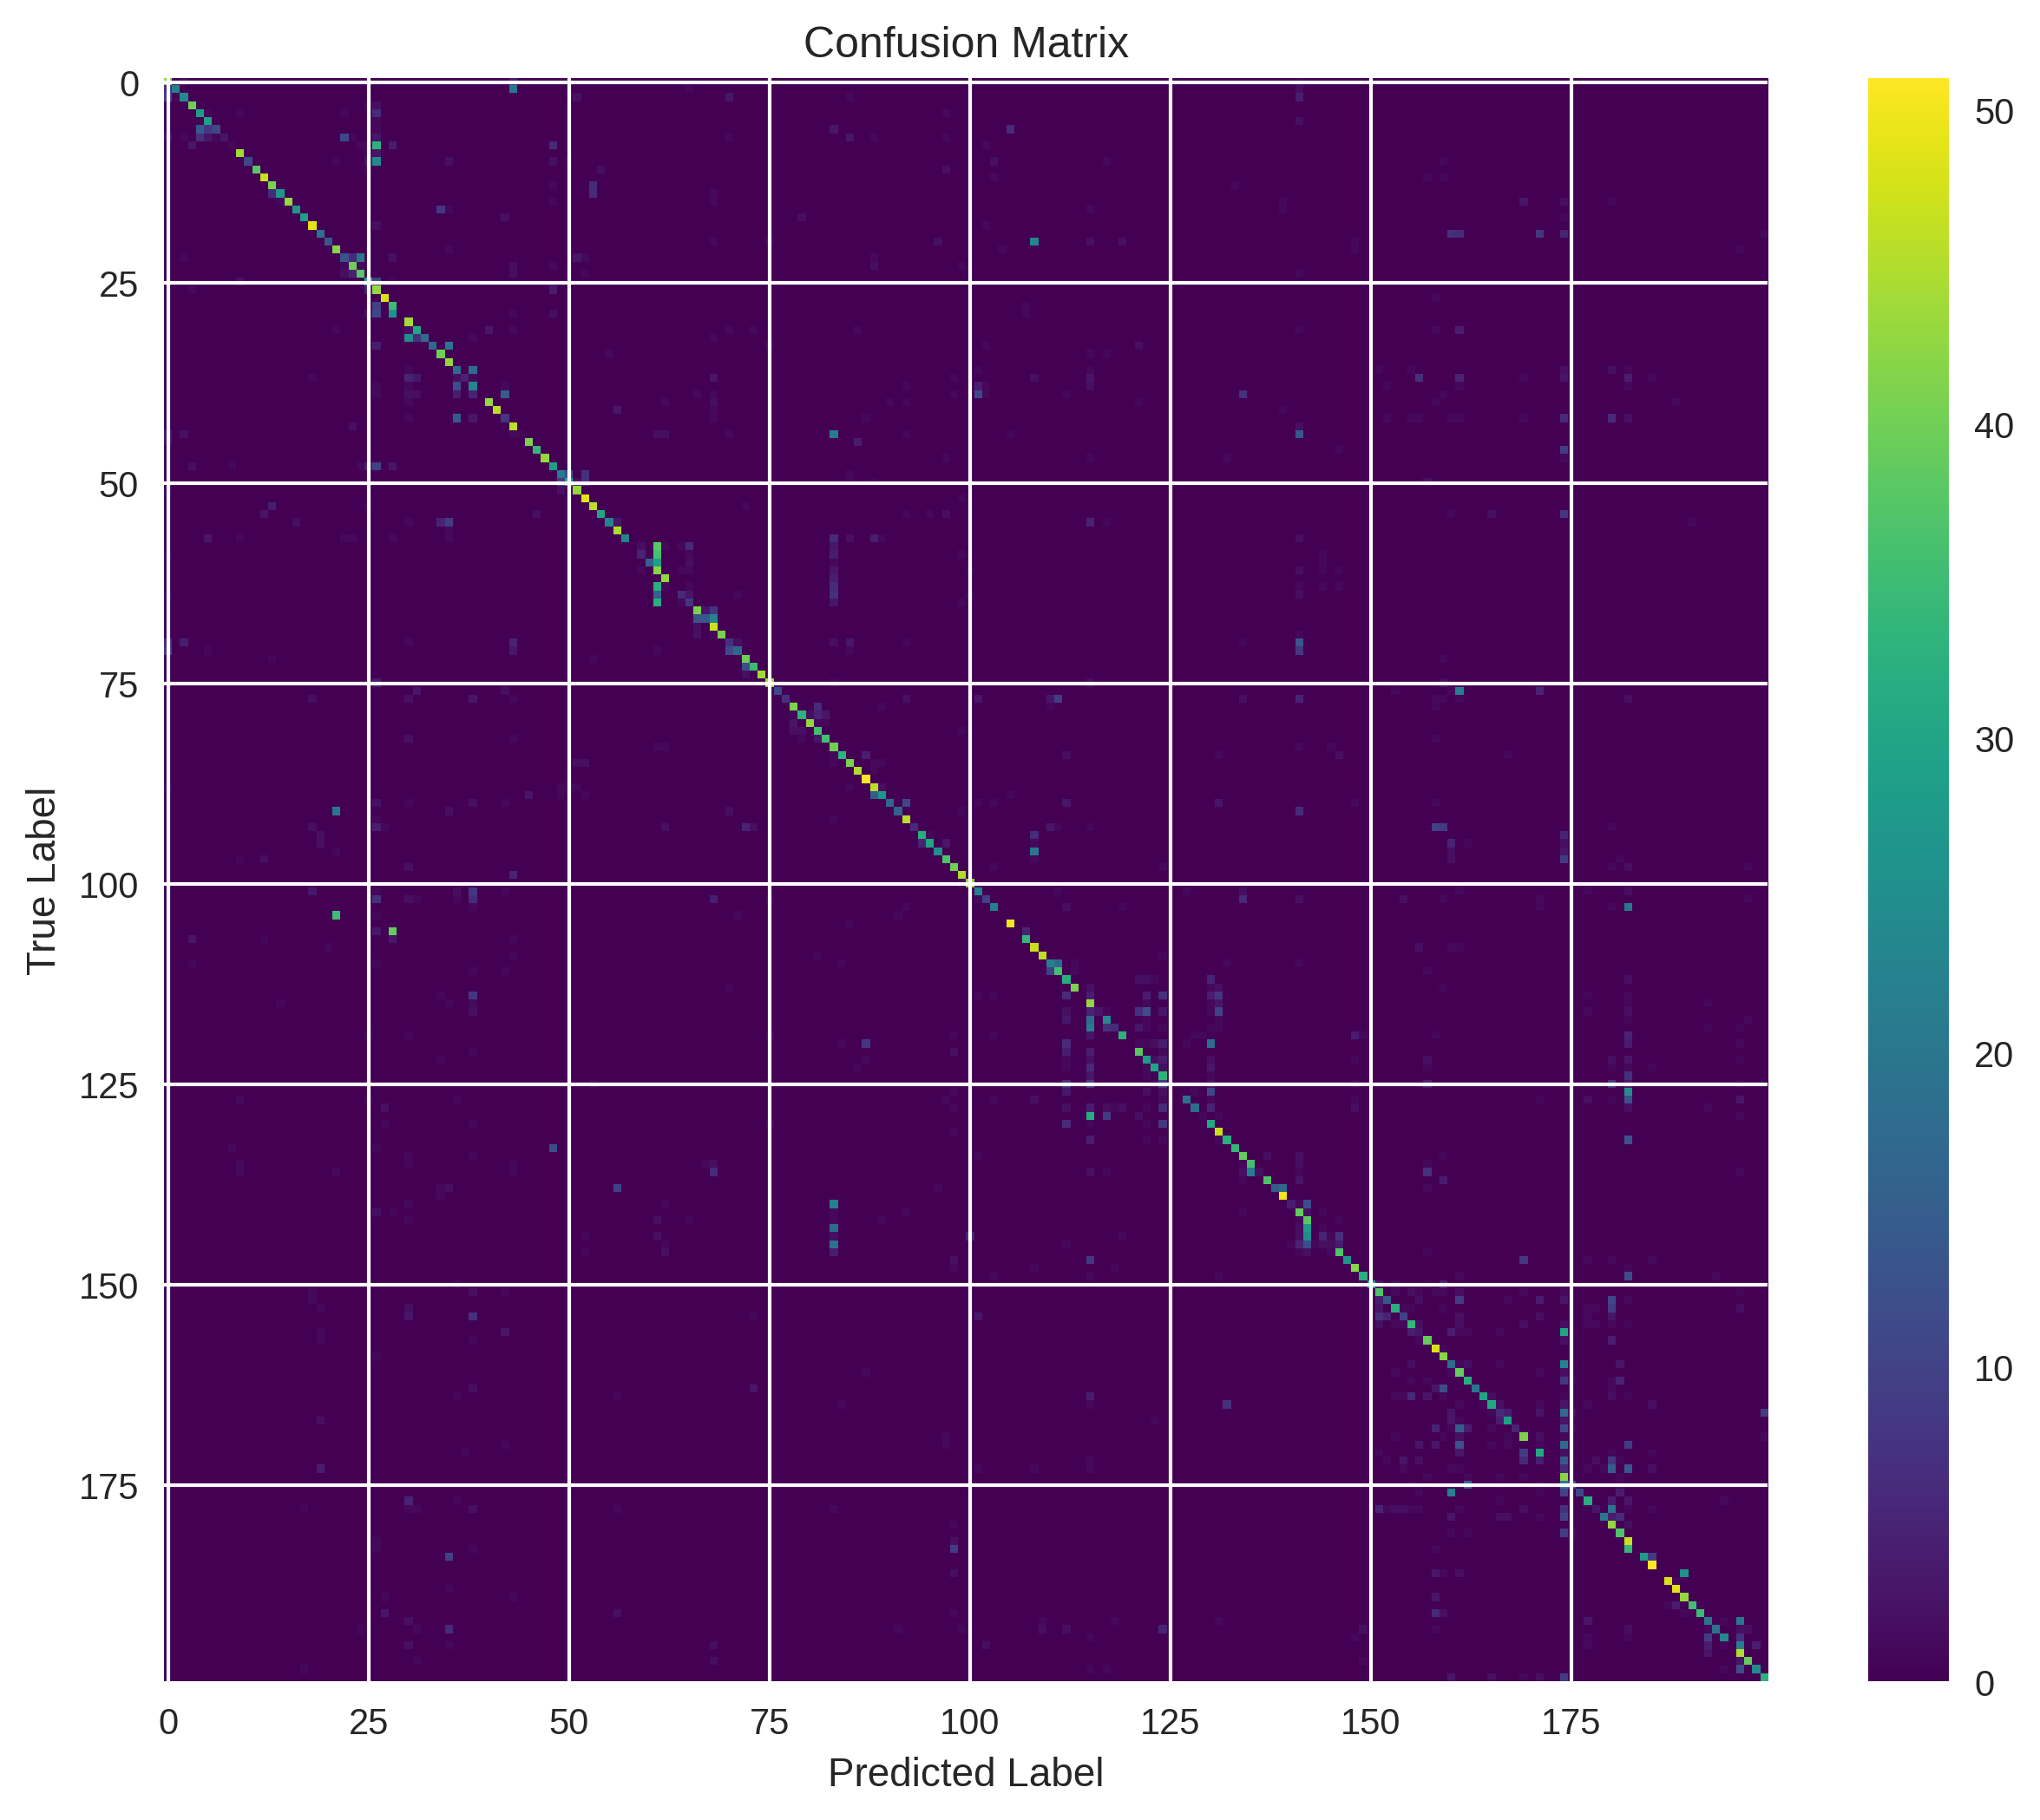

In [30]:
draw_confusion_matrix(trainer.nets[1], train_loader_preprocessed, device)

In [34]:
@torch.no_grad()
def cbm_interpretability_scores(model, processor, concepts, image, device):
    """
    Draws an interpretability bars showing which concepts are highly activated for CBM
    Args:
        model: refers to the trained Concept Bottleneck Model 
        processor: makes a preprocessing of both images and texts in order to make them acceptable by model
    Return:
        cbl_logits: outputs of the Concept Bottleneck Layer, each component of the output corresponds to some concept
    """
    with torch.no_grad():
        model.to(device)
        inputs = processor(text=concepts, images=image, return_tensors="pt", padding=True).to(device)
        cbl_logits, logits = model(**inputs)
    return cbl_logits

In [31]:
processor = transformers.CLIPProcessor.from_pretrained(Constants.clip_large_link)

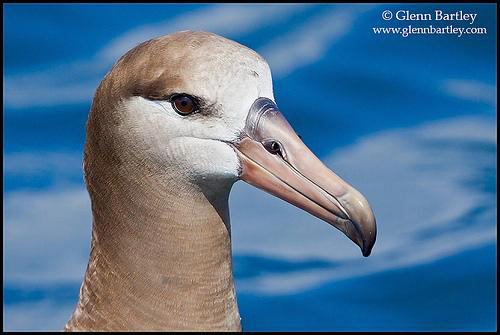

In [32]:
import PIL

image = PIL.Image.open("image.jpg")
image

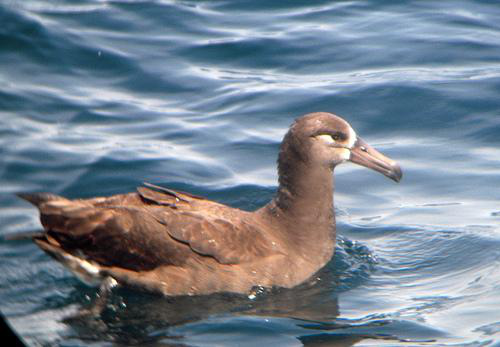

In [41]:
image_2 = PIL.Image.open('image-2.jpg')
image_2

**gumbel**

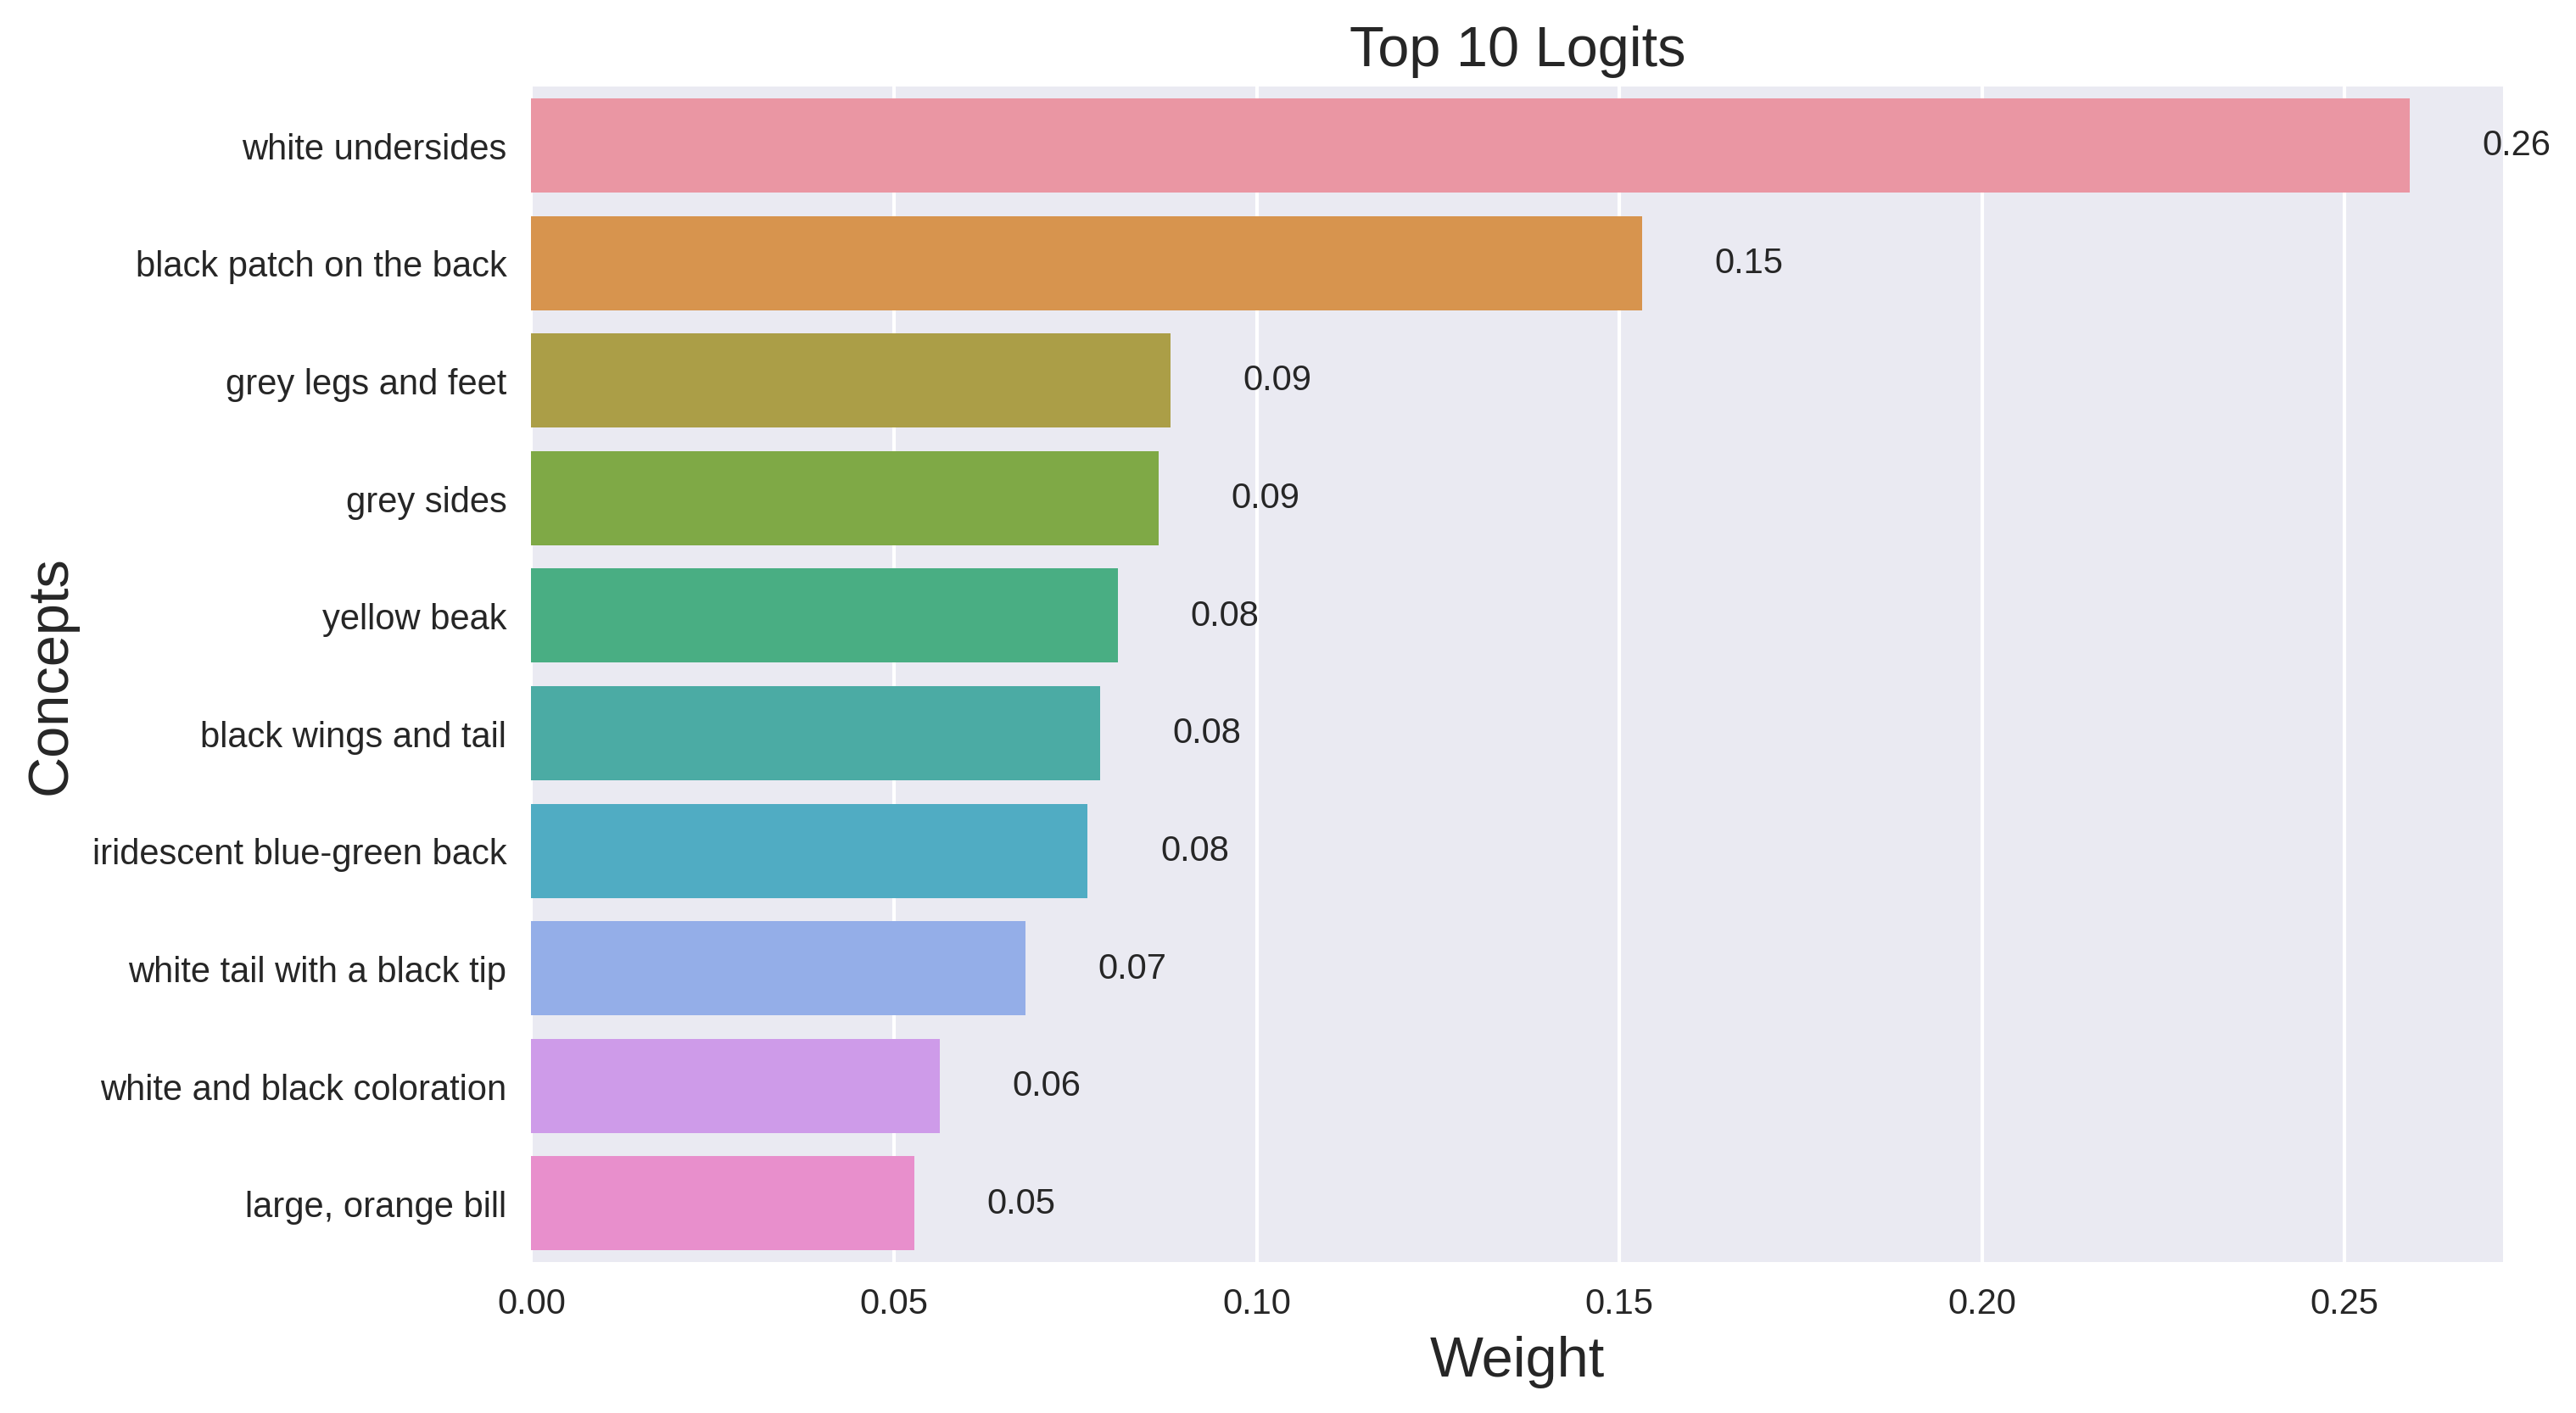

In [38]:
probs = cbm_interpretability_scores(trainer.nets[0], processor, concepts, image, device)
draw_bottleneck(image, probs, k=10, concepts=concepts, draw_probs=True)

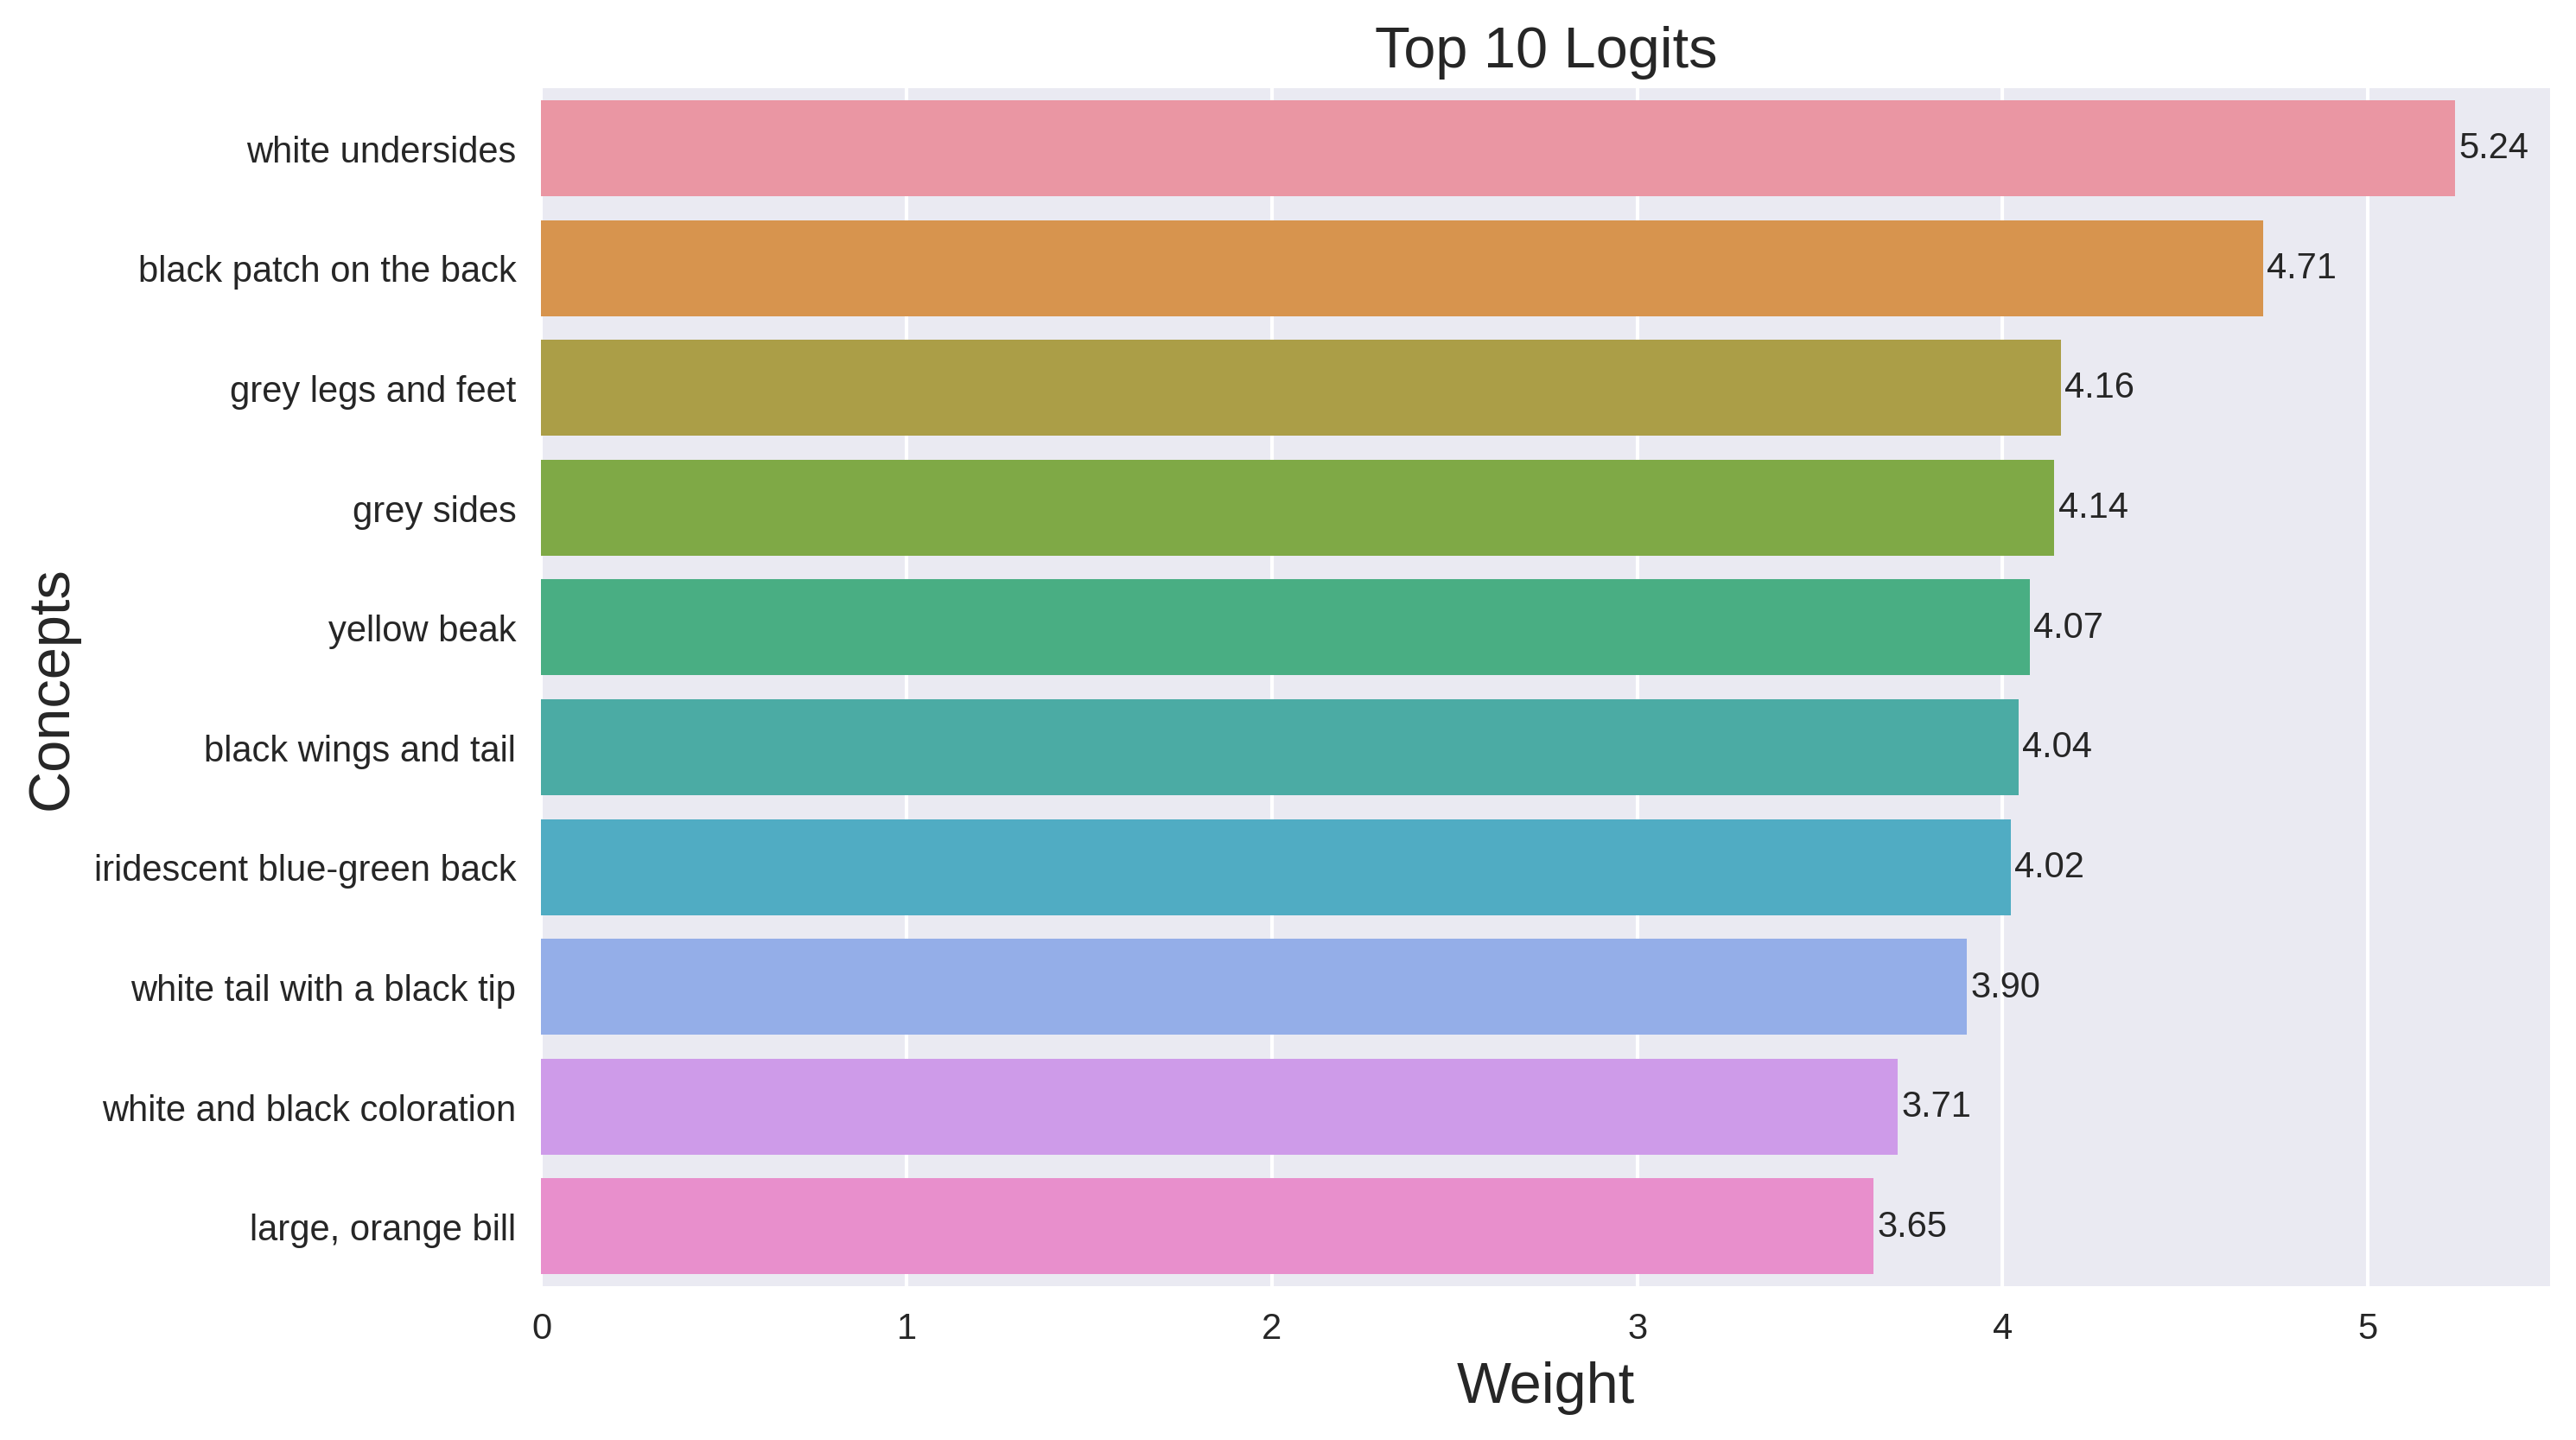

In [39]:
probs = cbm_interpretability_scores(trainer.nets[0], processor, concepts, image, device)
draw_bottleneck(image, probs, k=10, concepts=concepts, draw_probs=False)

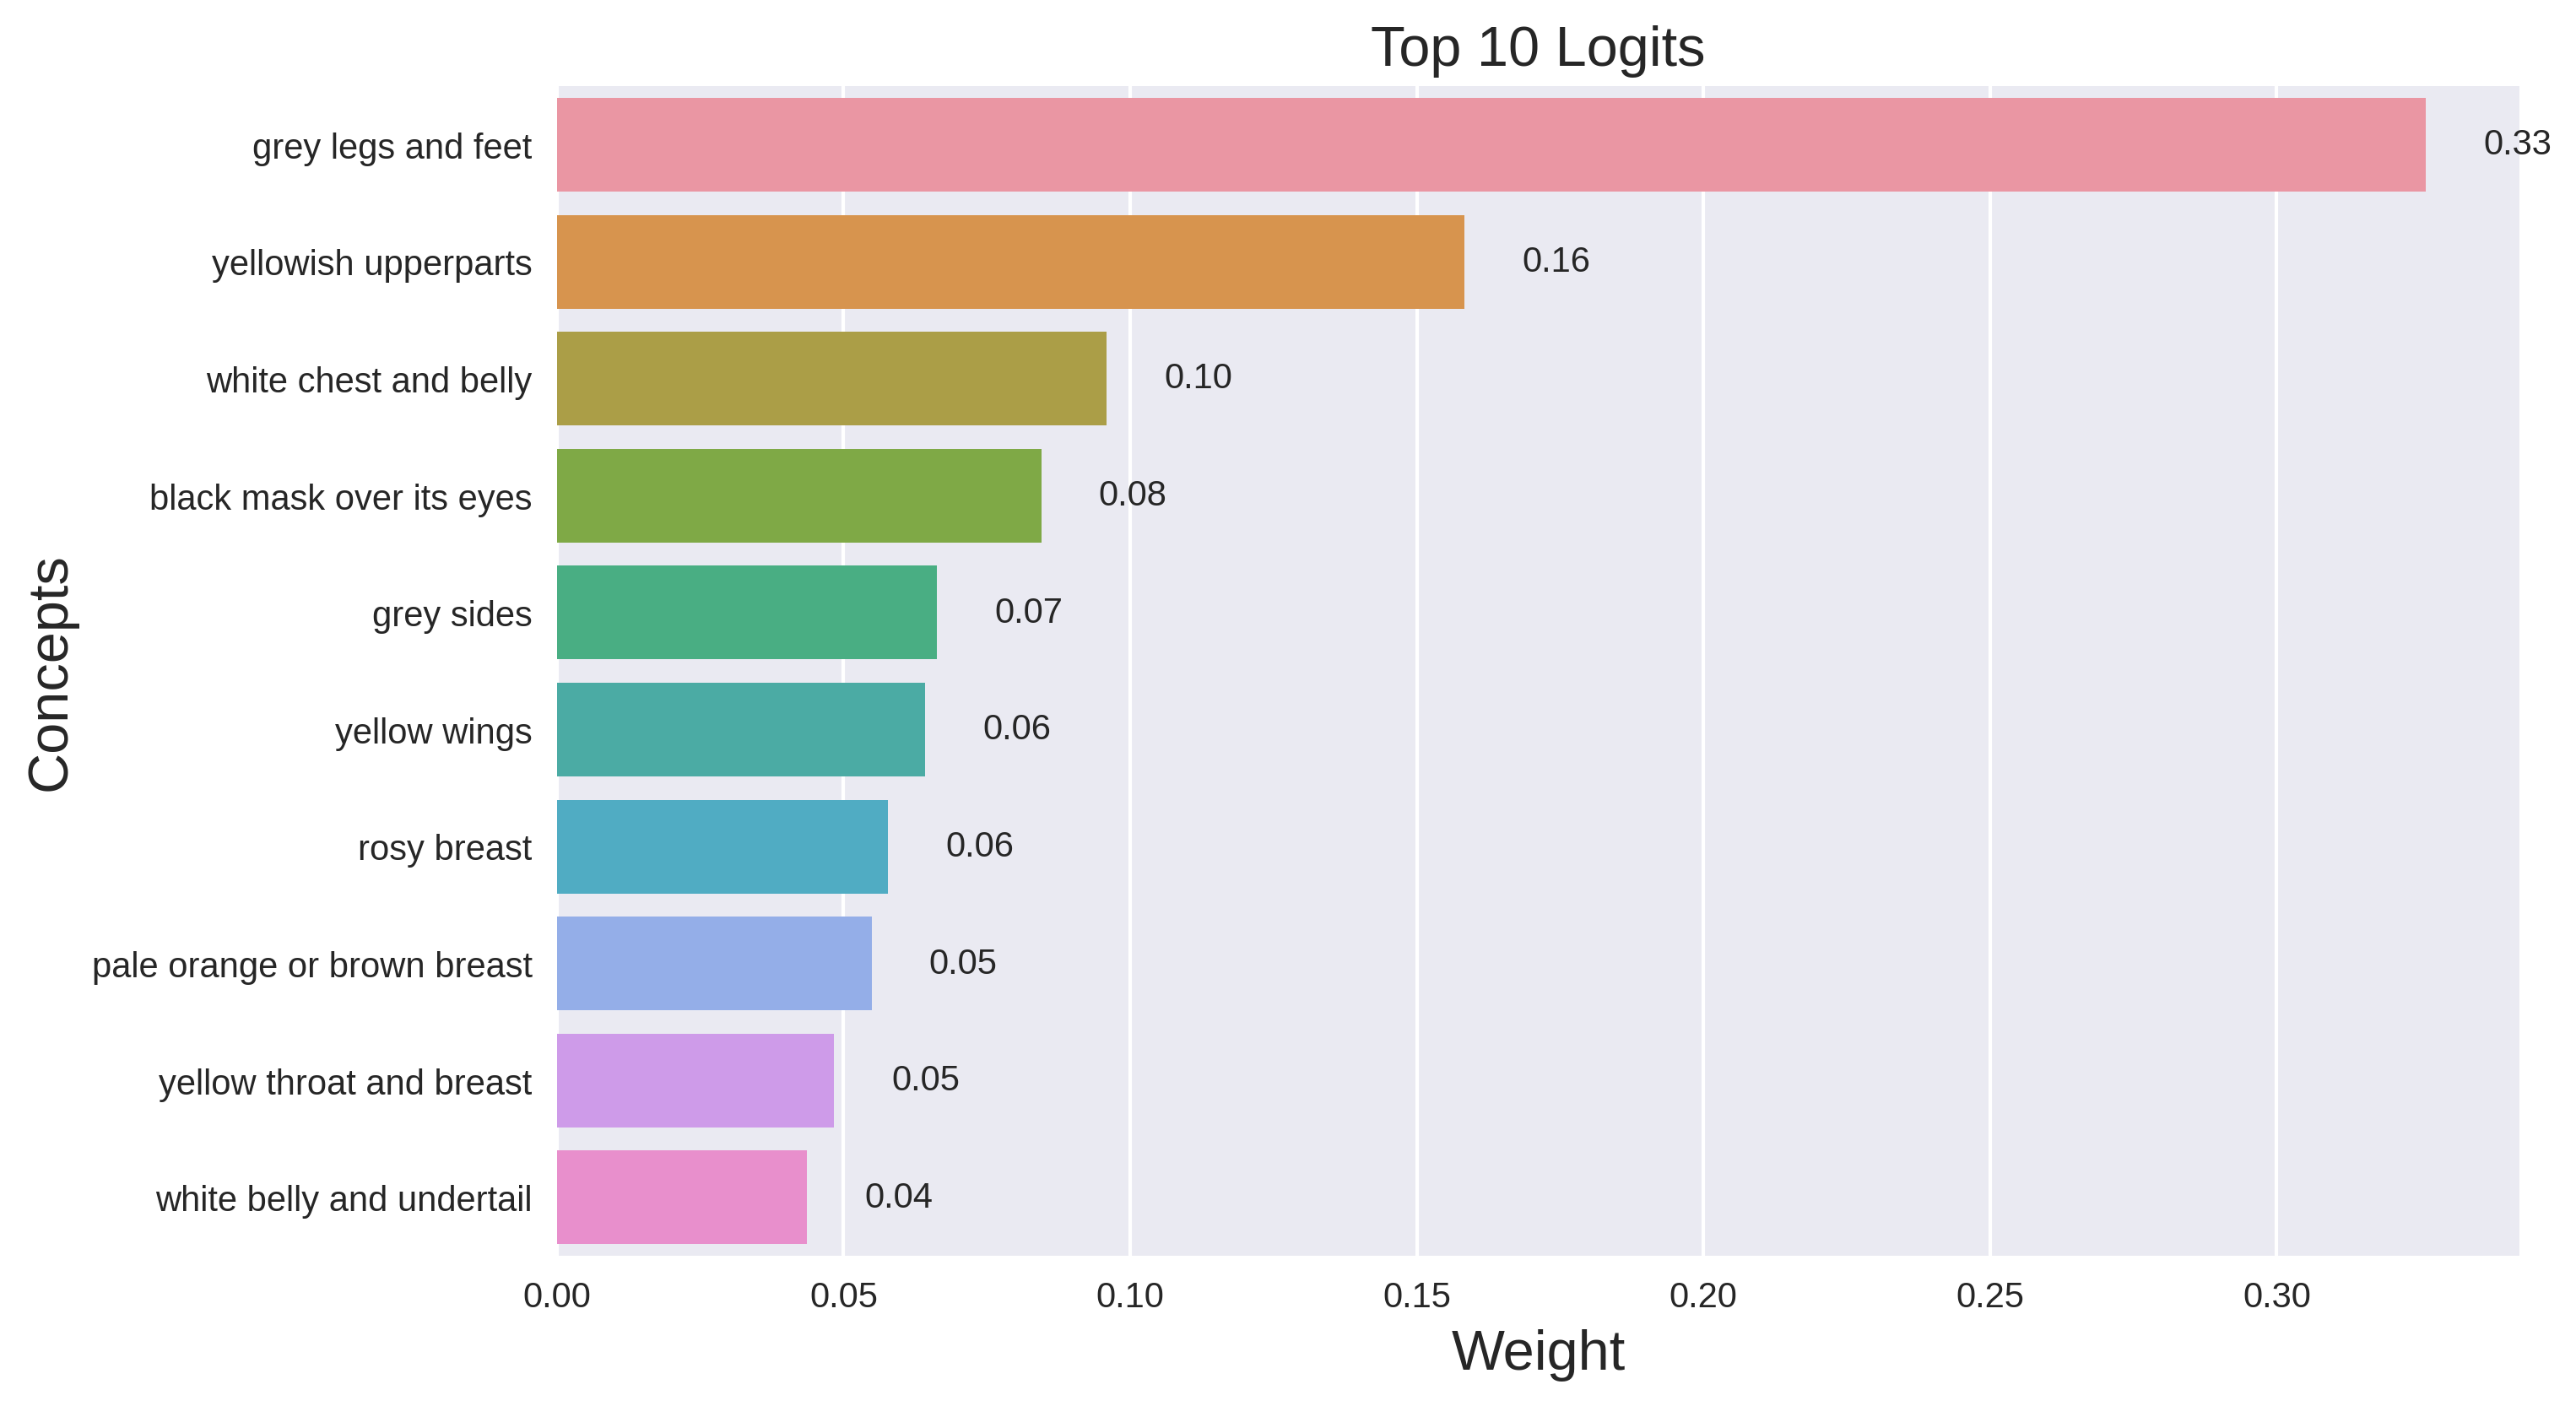

In [42]:
probs = cbm_interpretability_scores(trainer.nets[0], processor, concepts, image_2, device)
draw_bottleneck(image_2, probs, k=10, concepts=concepts, draw_probs=True)

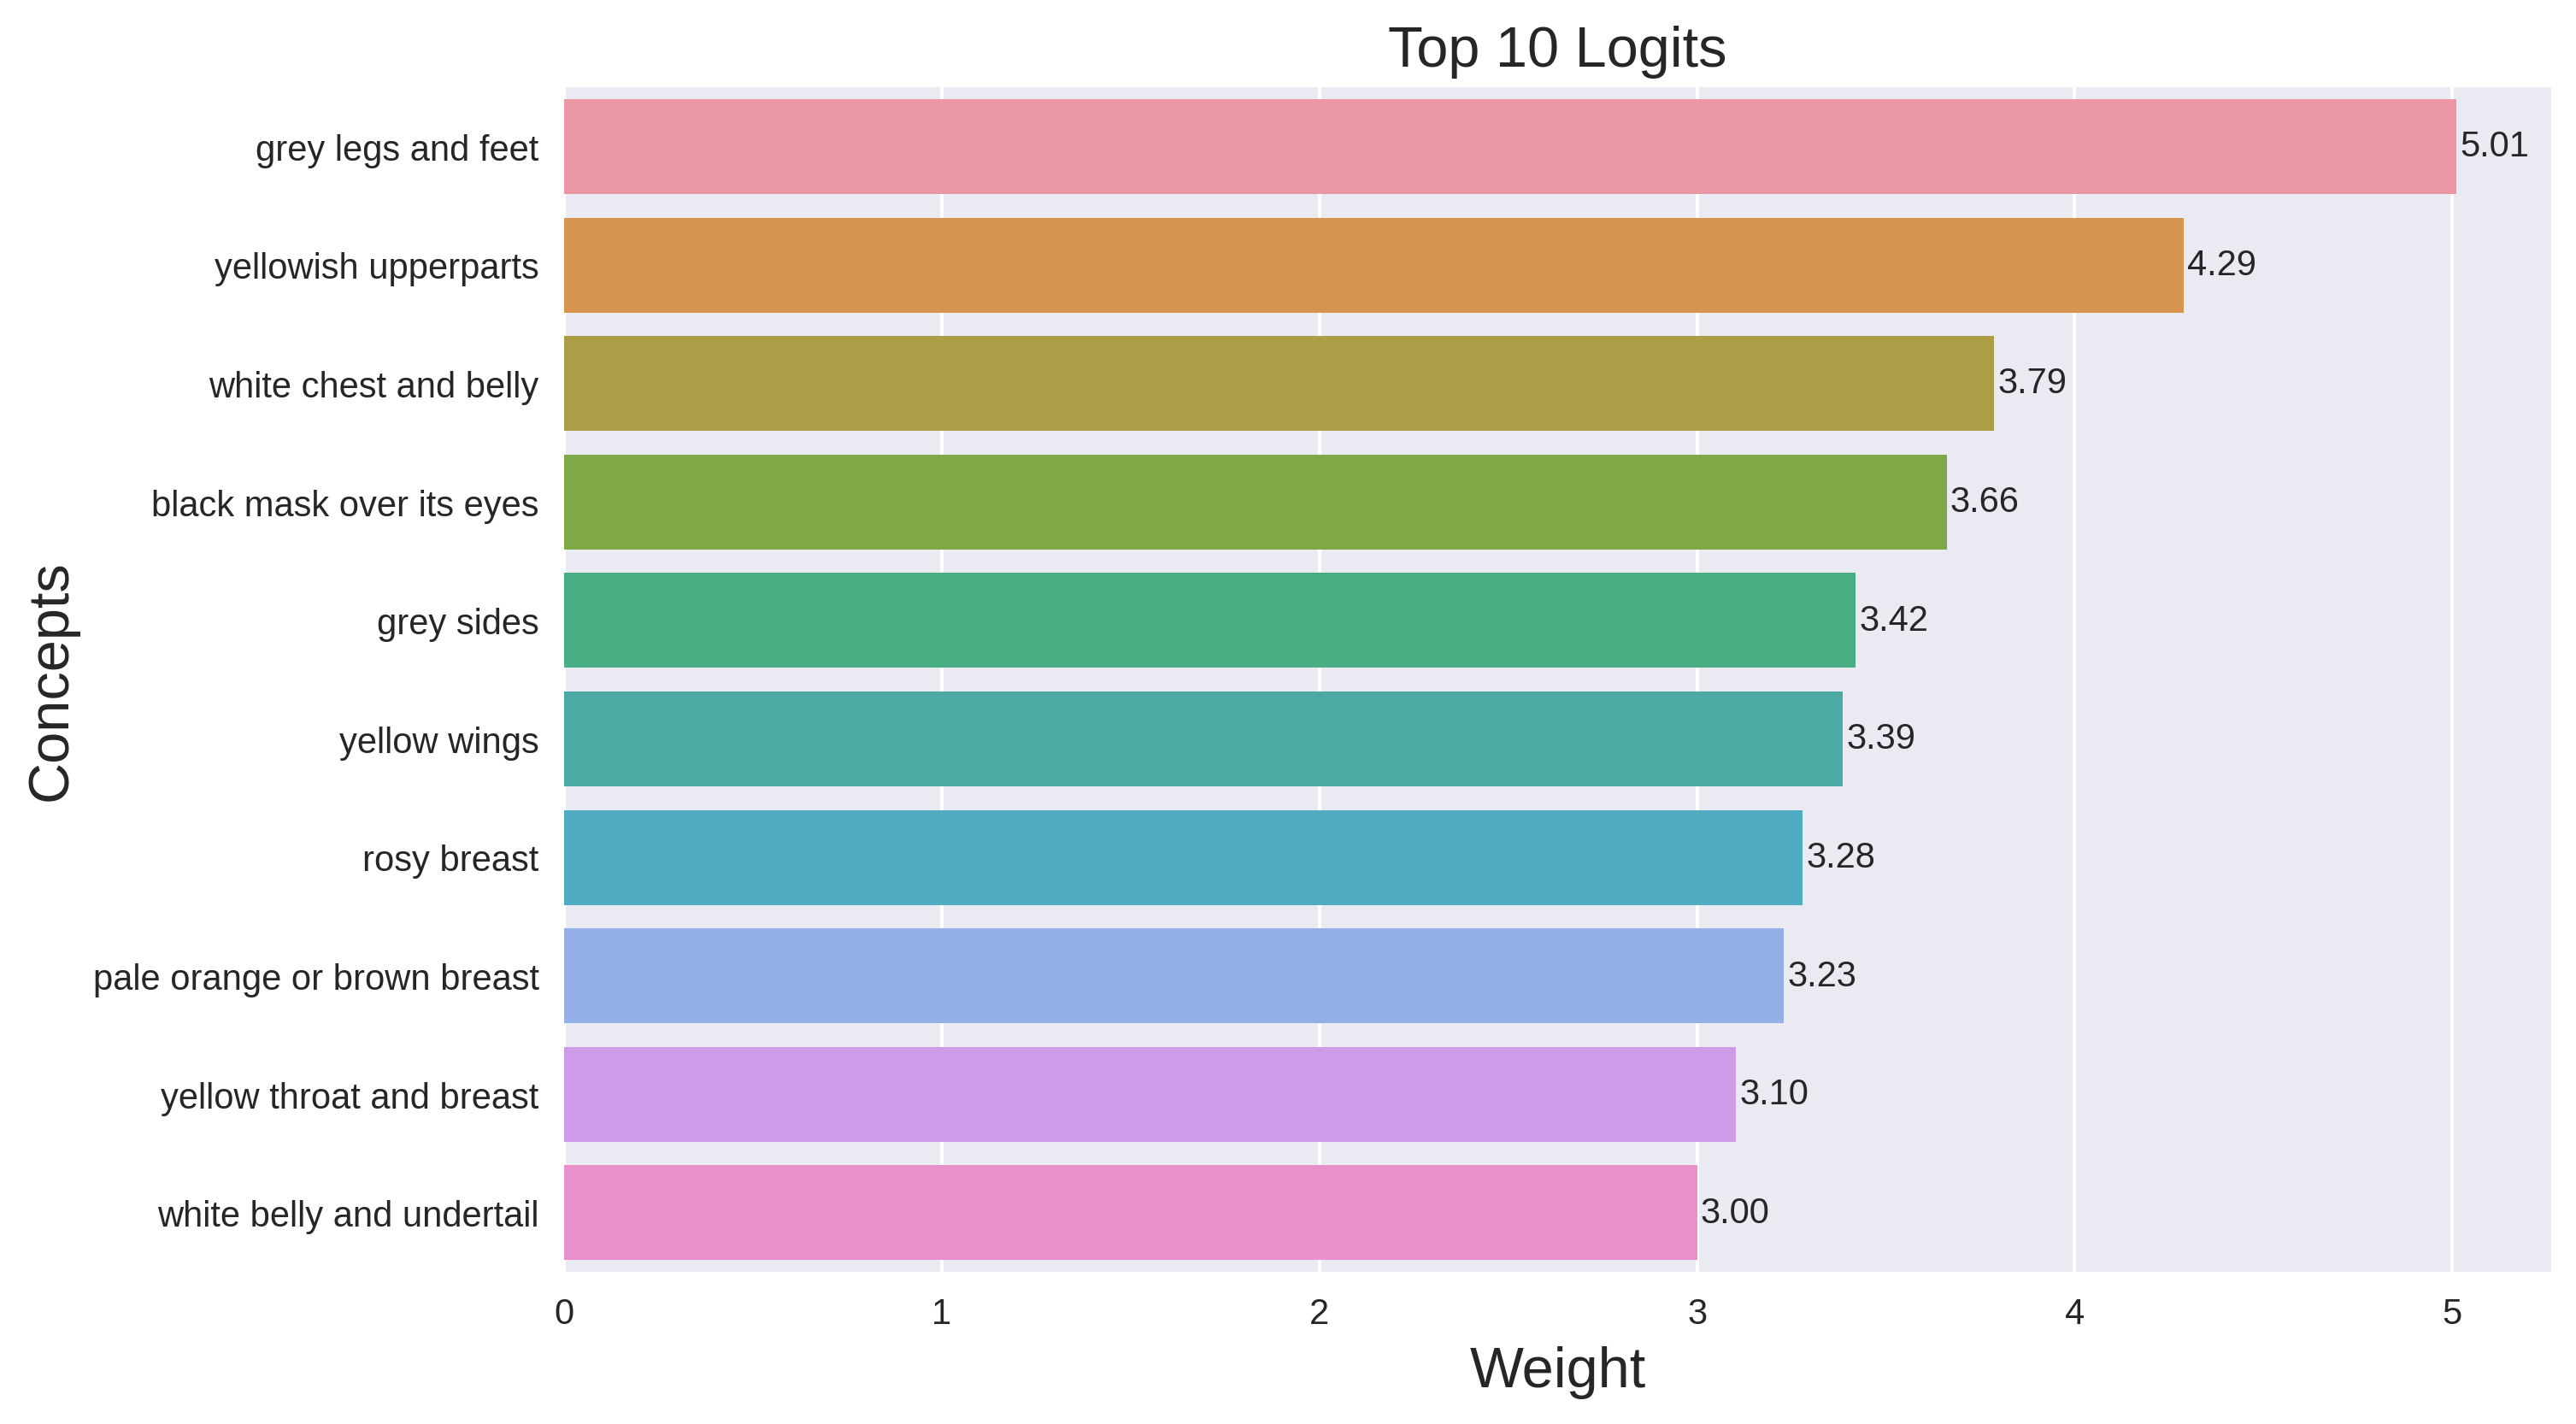

In [43]:
probs = cbm_interpretability_scores(trainer.nets[0], processor, concepts, image_2, device)
draw_bottleneck(image_2, probs, k=10, concepts=concepts, draw_probs=False)

**contrastive**

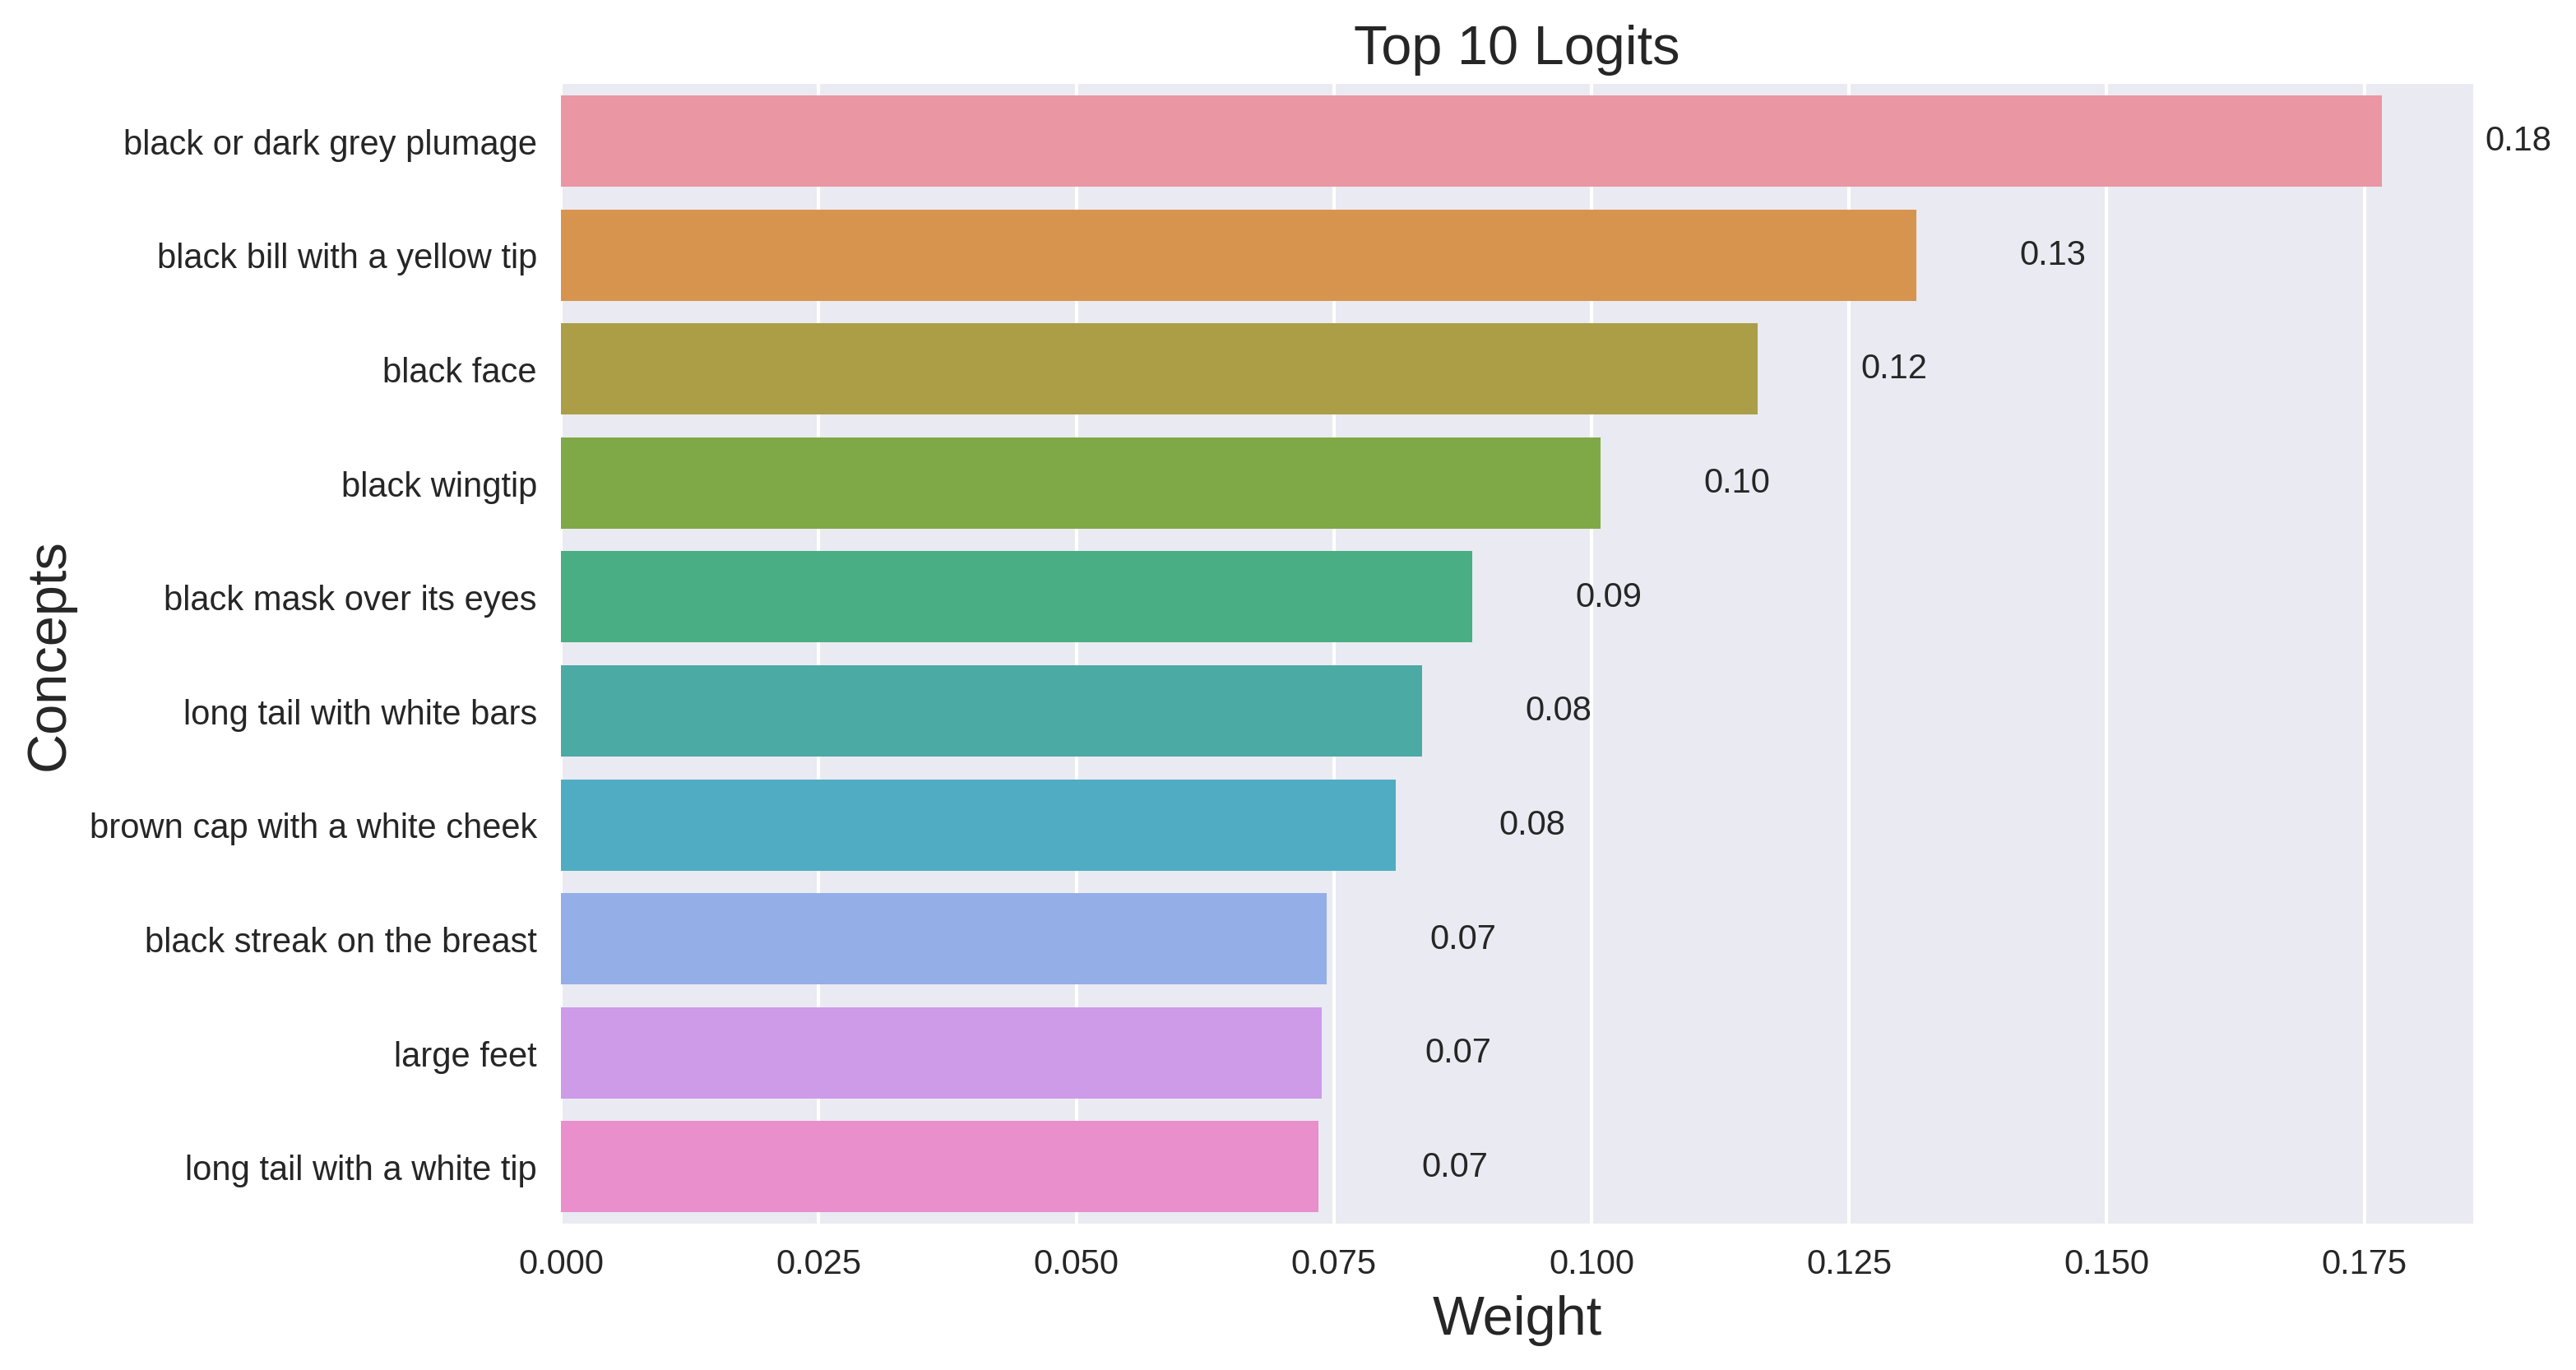

In [36]:
probs = cbm_interpretability_scores(trainer.nets[1], processor, concepts, image, device)
draw_bottleneck(image, probs, k=10, concepts=concepts, draw_probs=True)

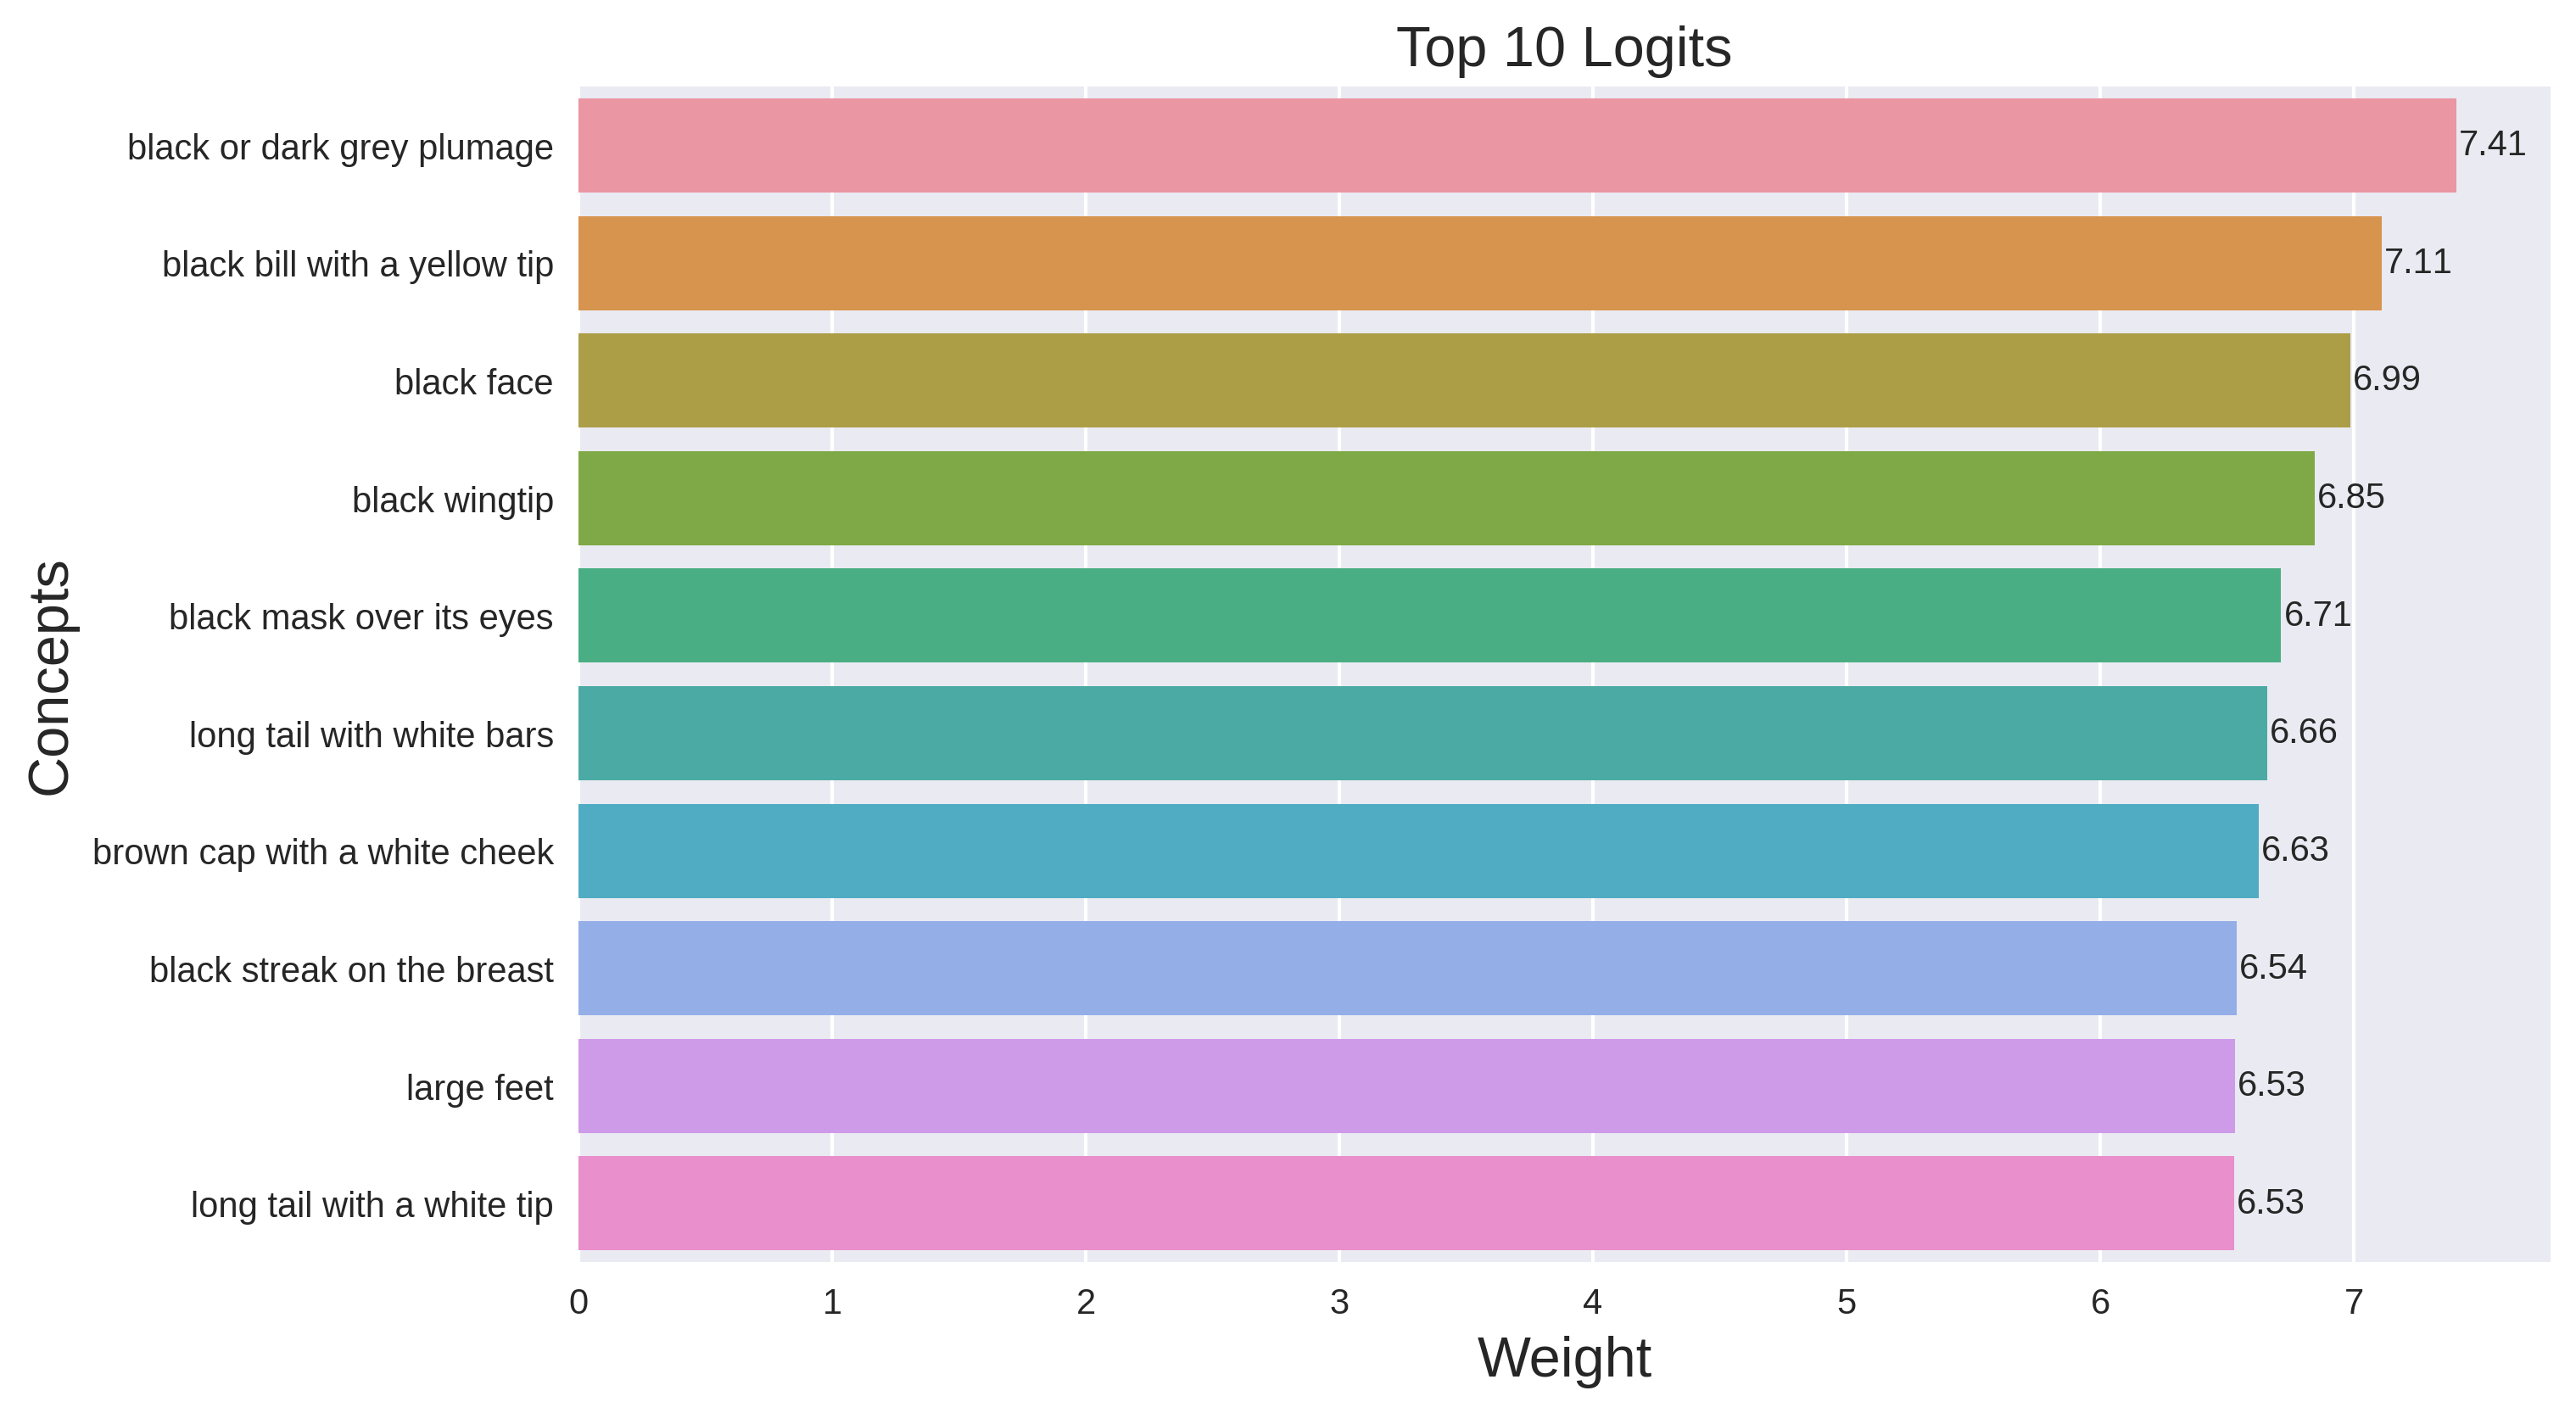

In [37]:
probs = cbm_interpretability_scores(trainer.nets[1], processor, concepts, image, device)
draw_bottleneck(image, probs, k=10, concepts=concepts, draw_probs=False)

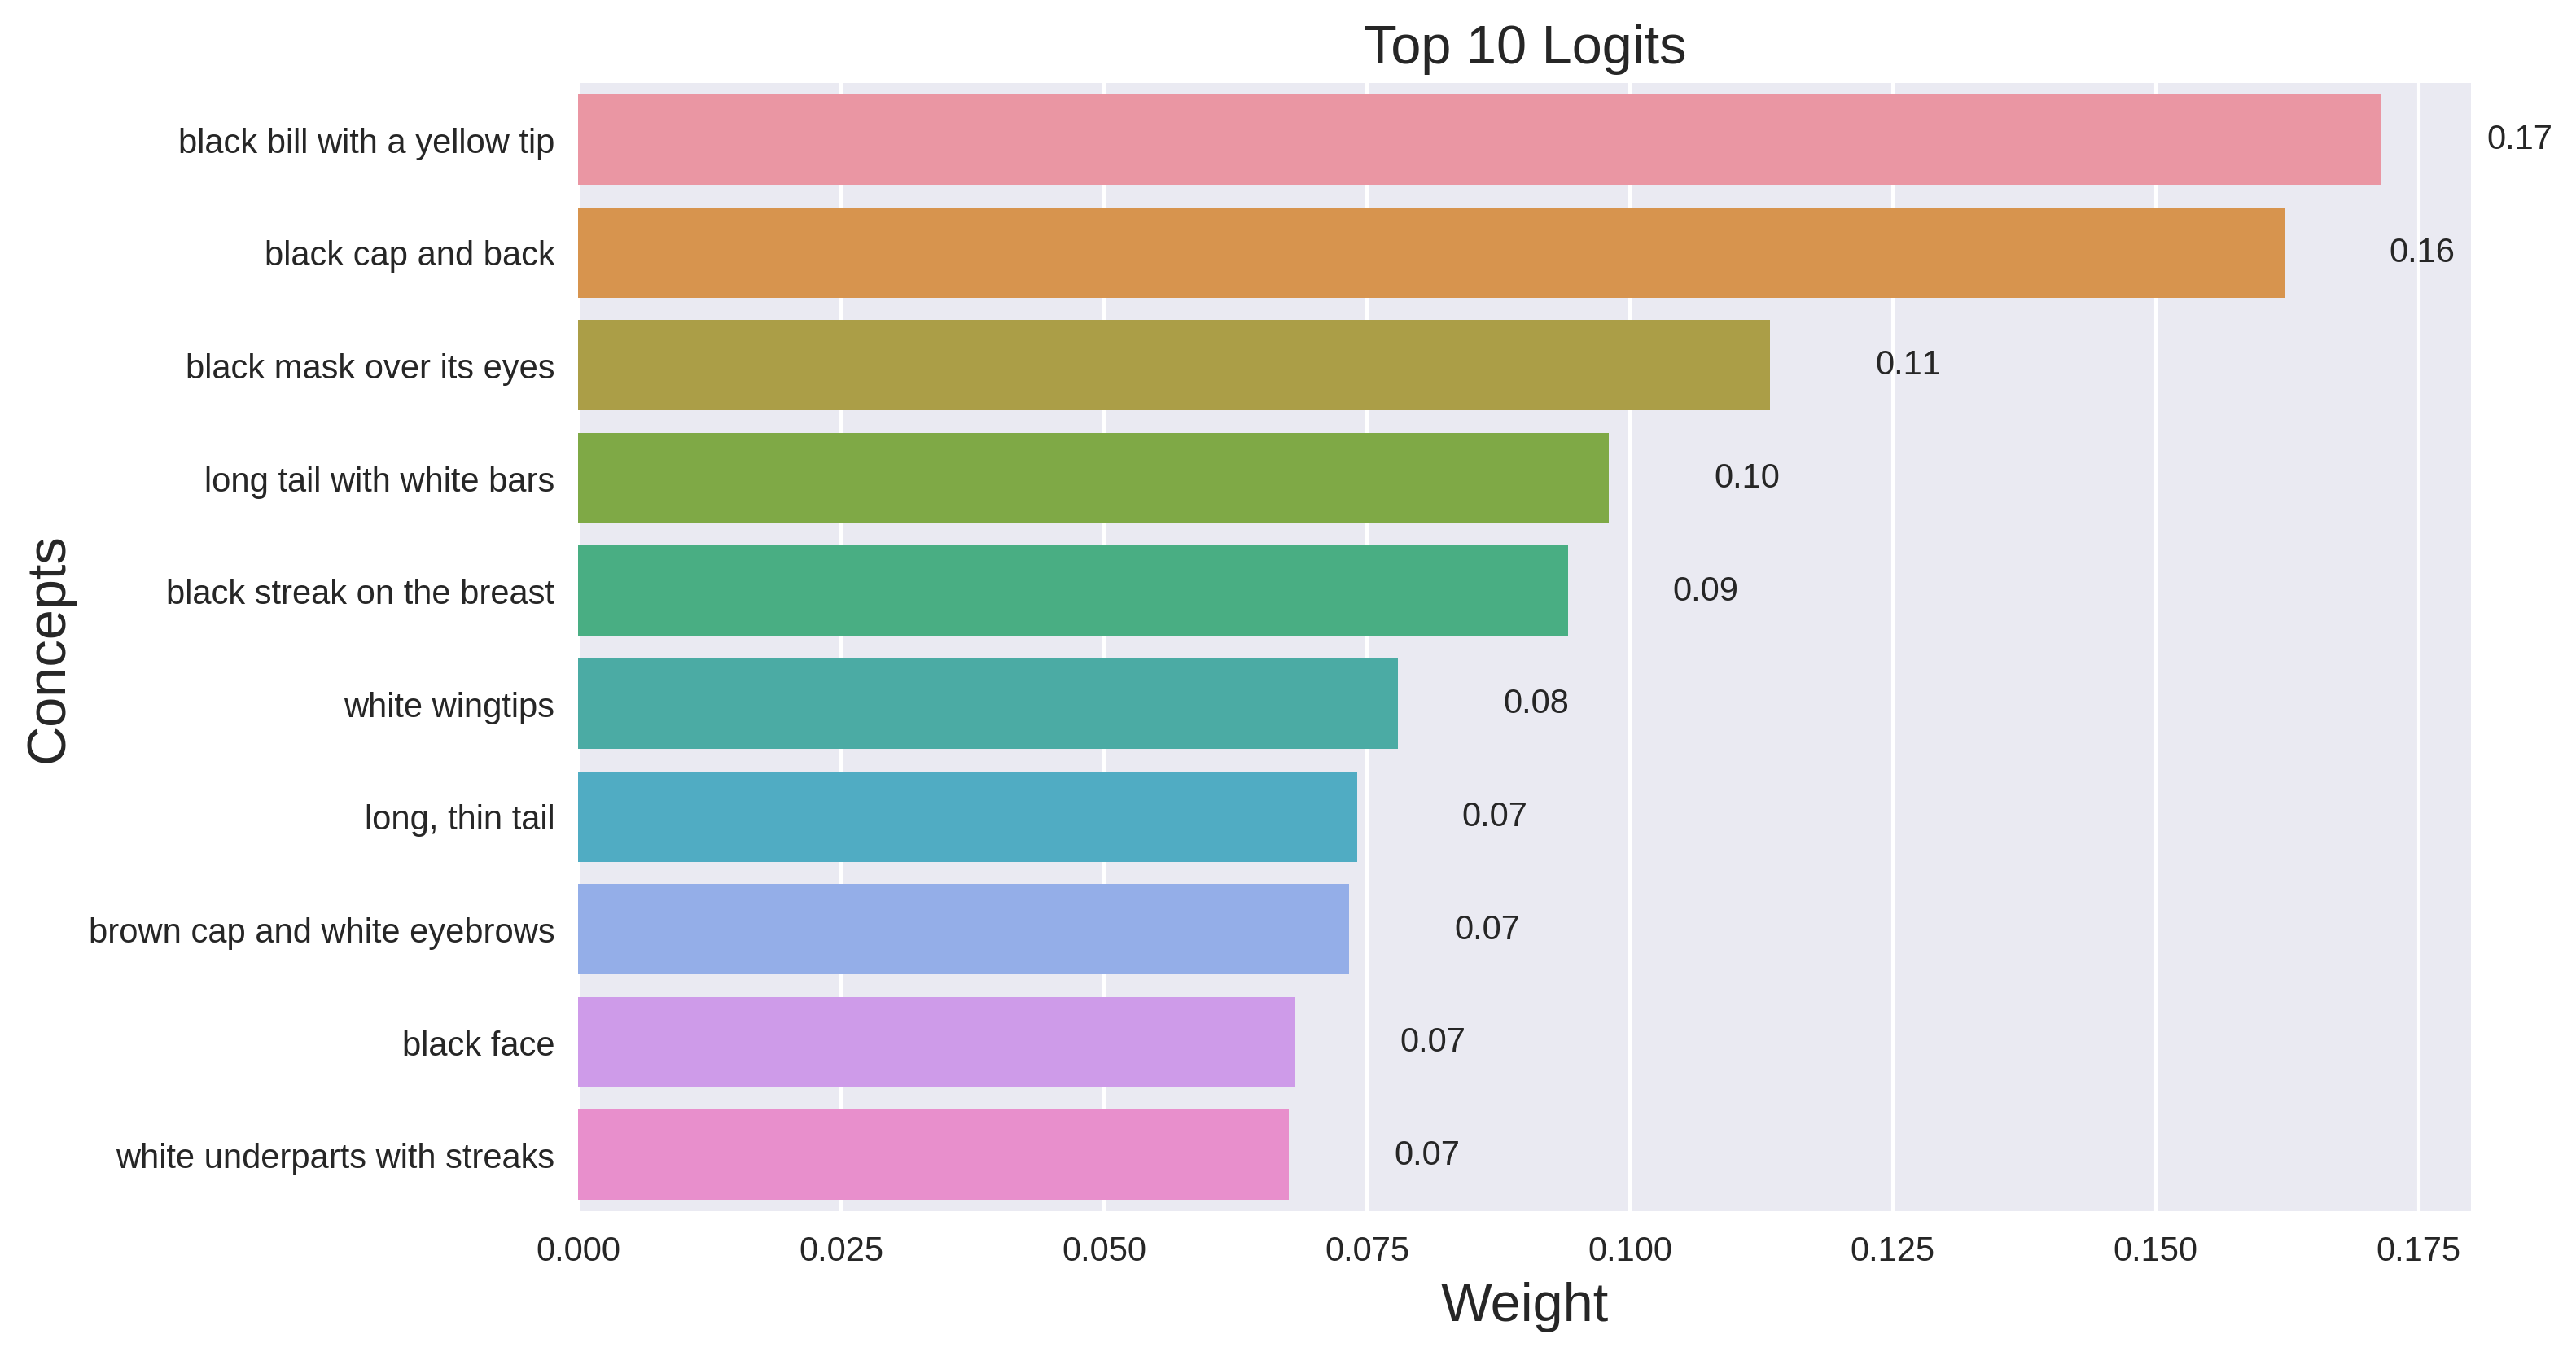

In [44]:
probs = cbm_interpretability_scores(trainer.nets[1], processor, concepts, image_2, device)
draw_bottleneck(image_2, probs, k=10, concepts=concepts, draw_probs=True)

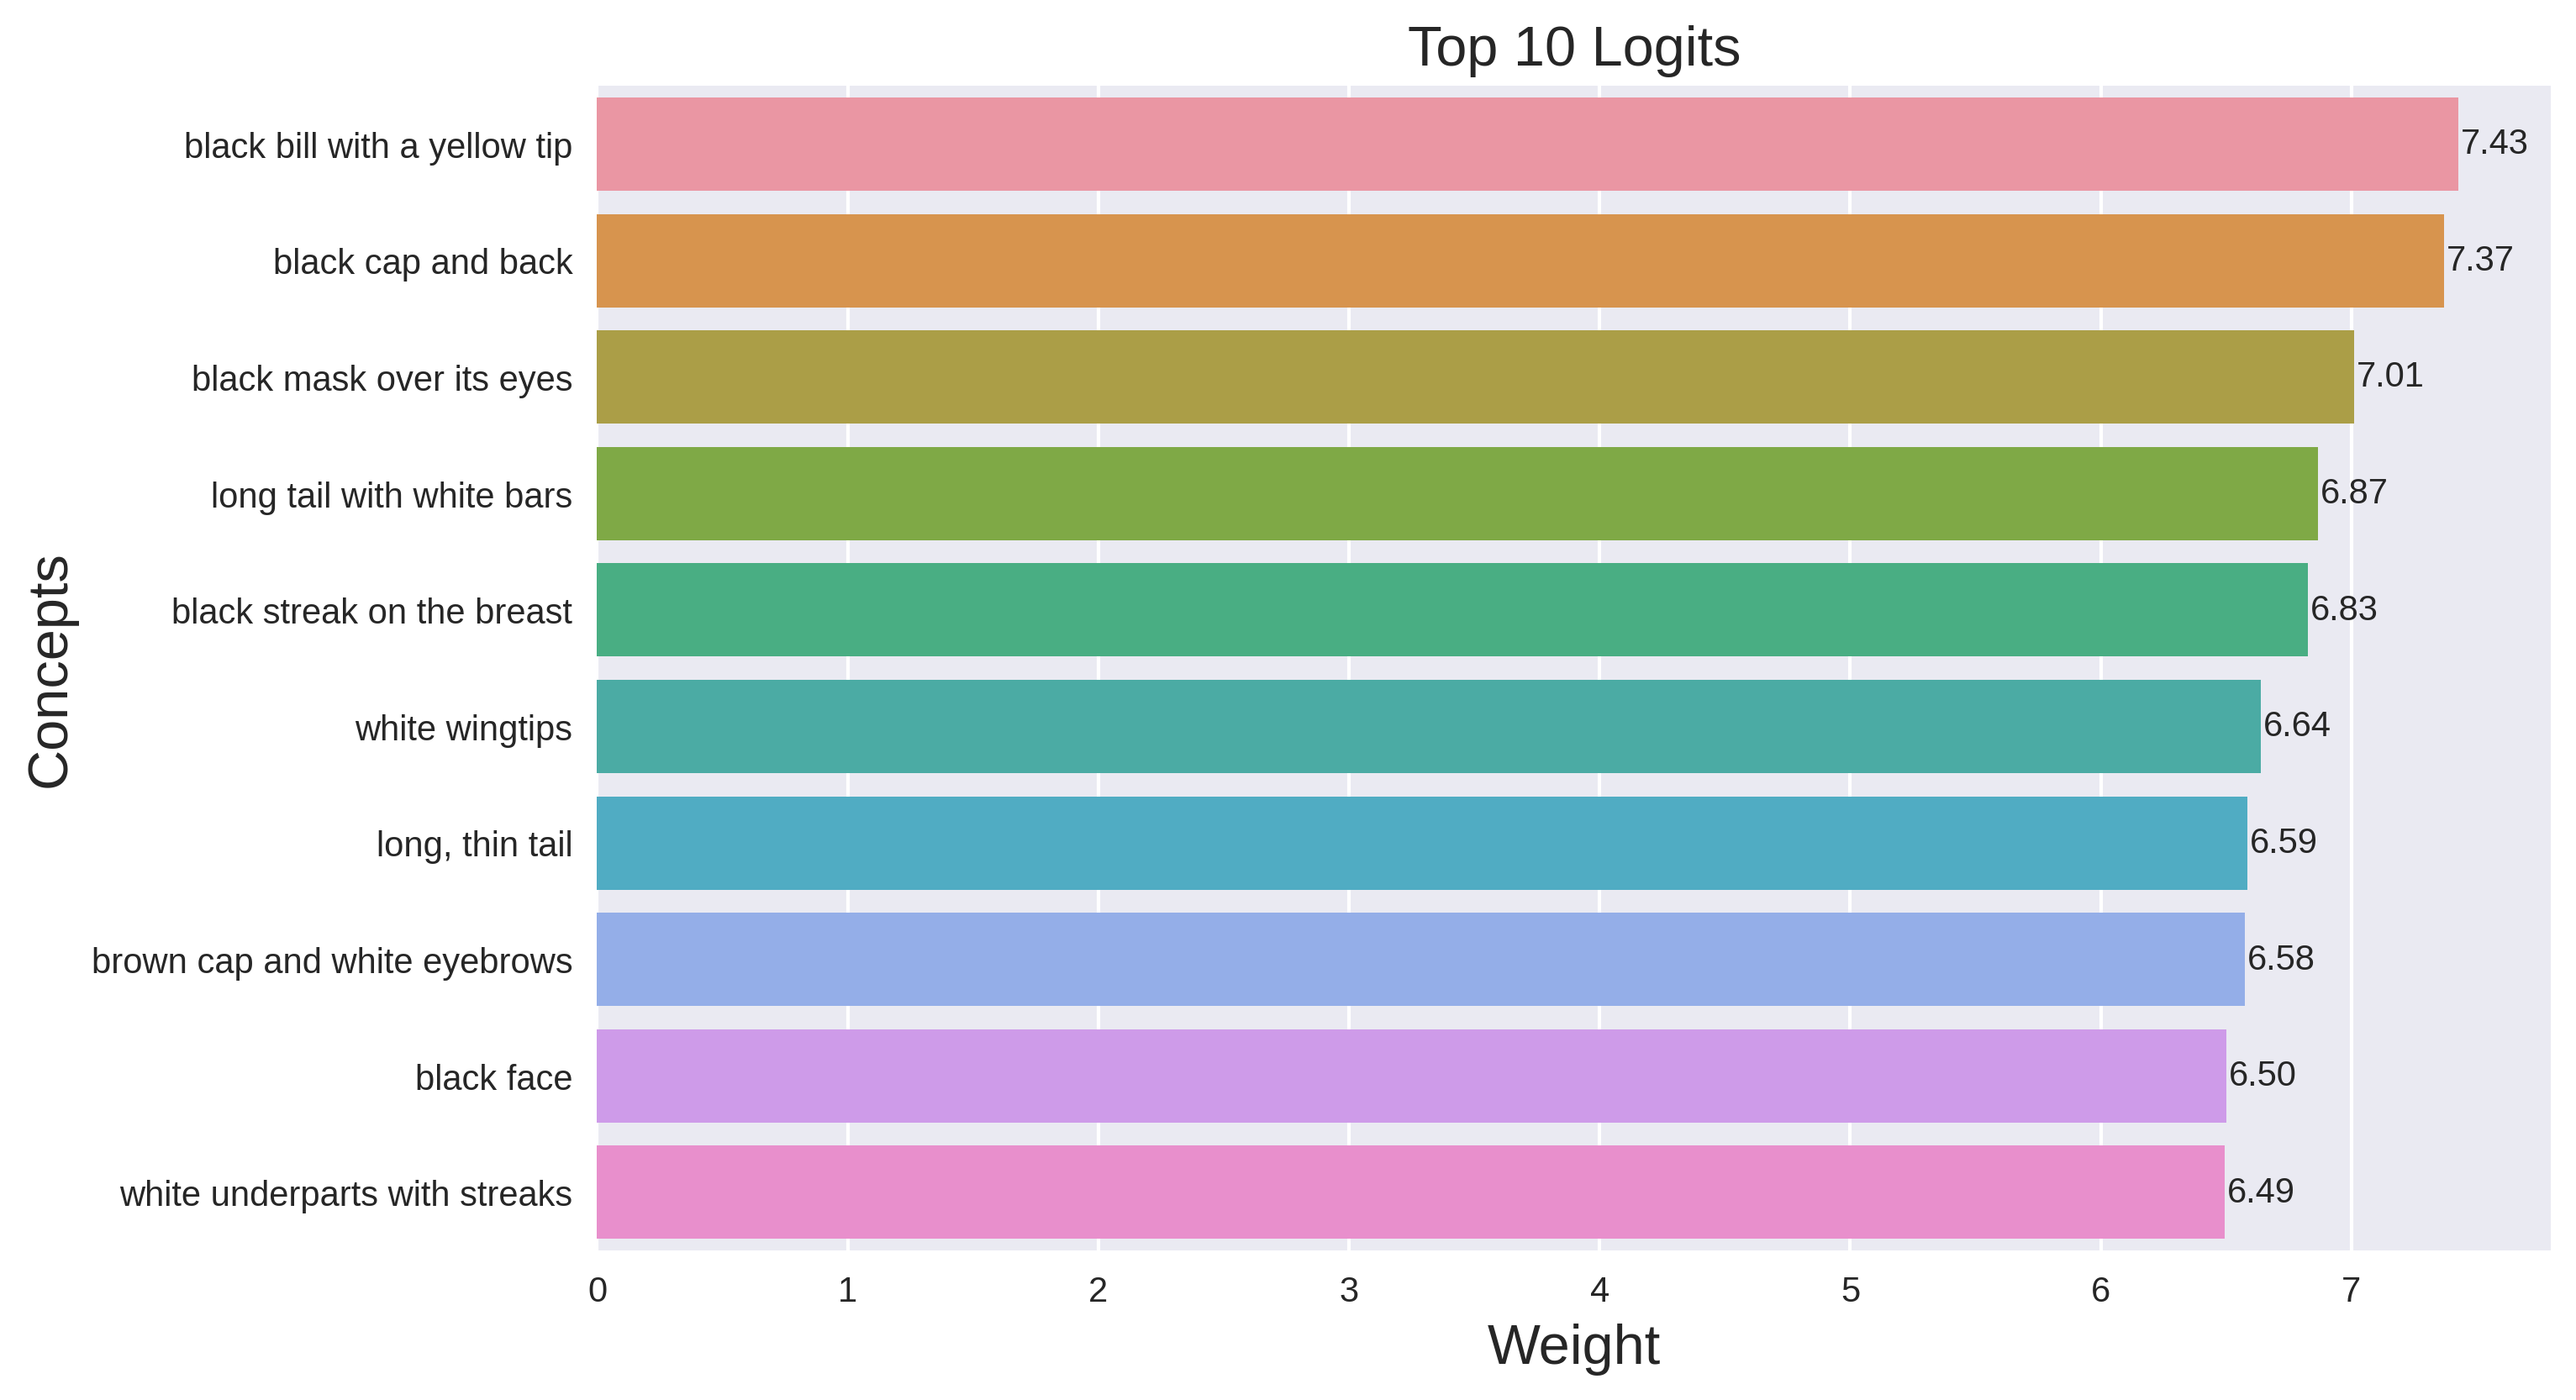

In [45]:
probs = cbm_interpretability_scores(trainer.nets[1], processor, concepts, image_2, device)
draw_bottleneck(image_2, probs, k=10, concepts=concepts, draw_probs=False)

<center>CLIP L/14, gumbel, 3e-4</center>

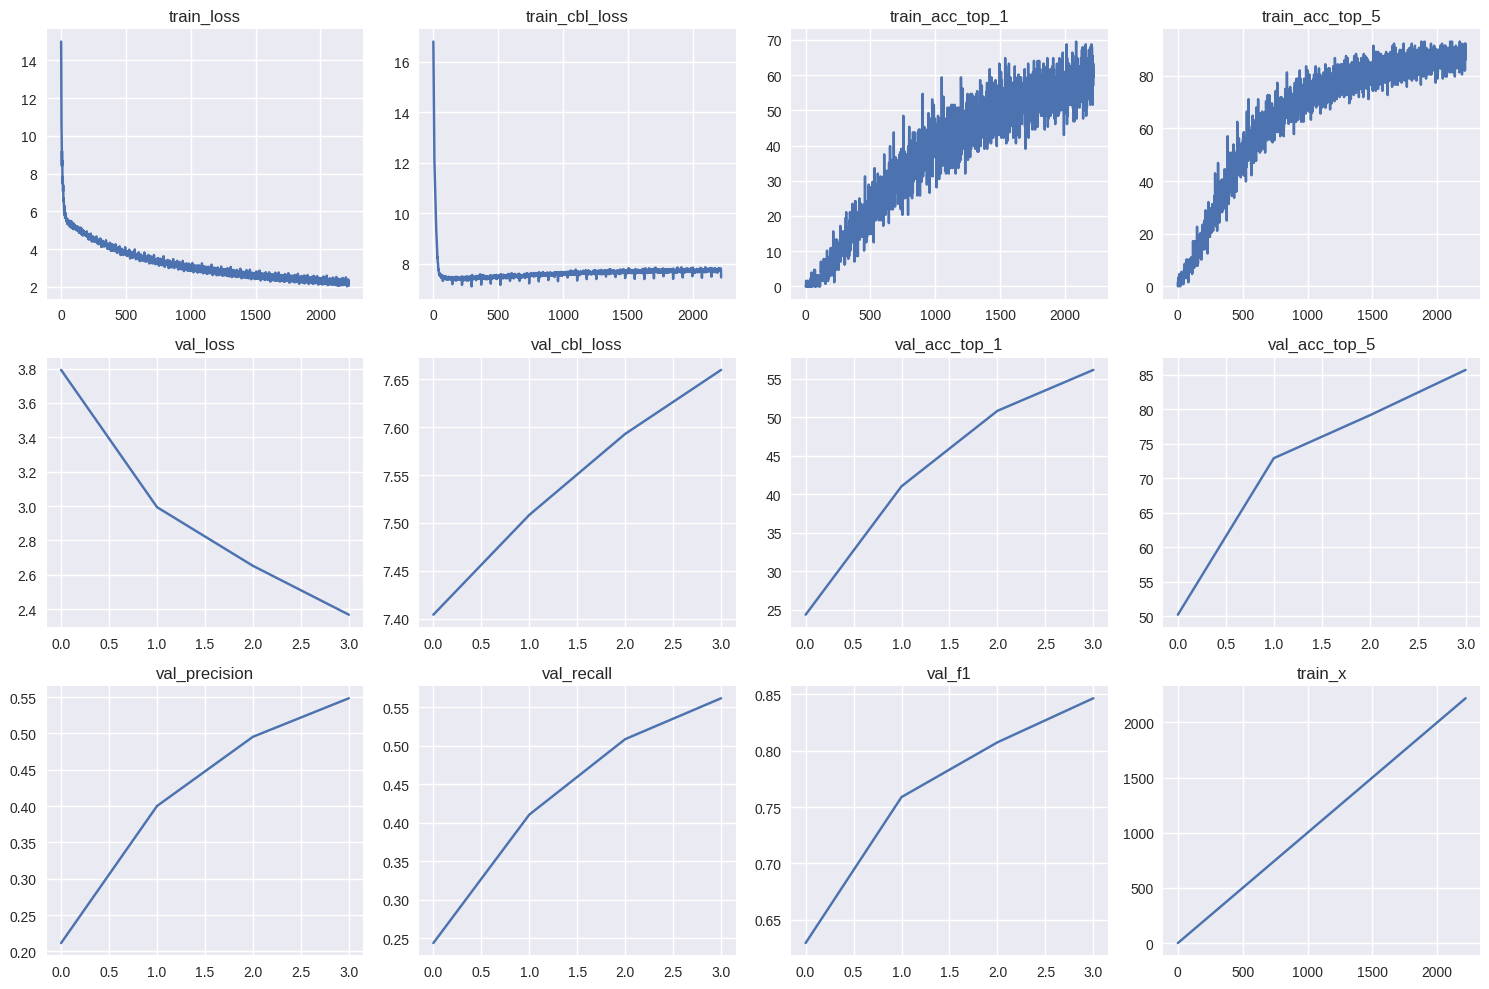

<center>CLIP L/14, contrastive, 3e-4</center>

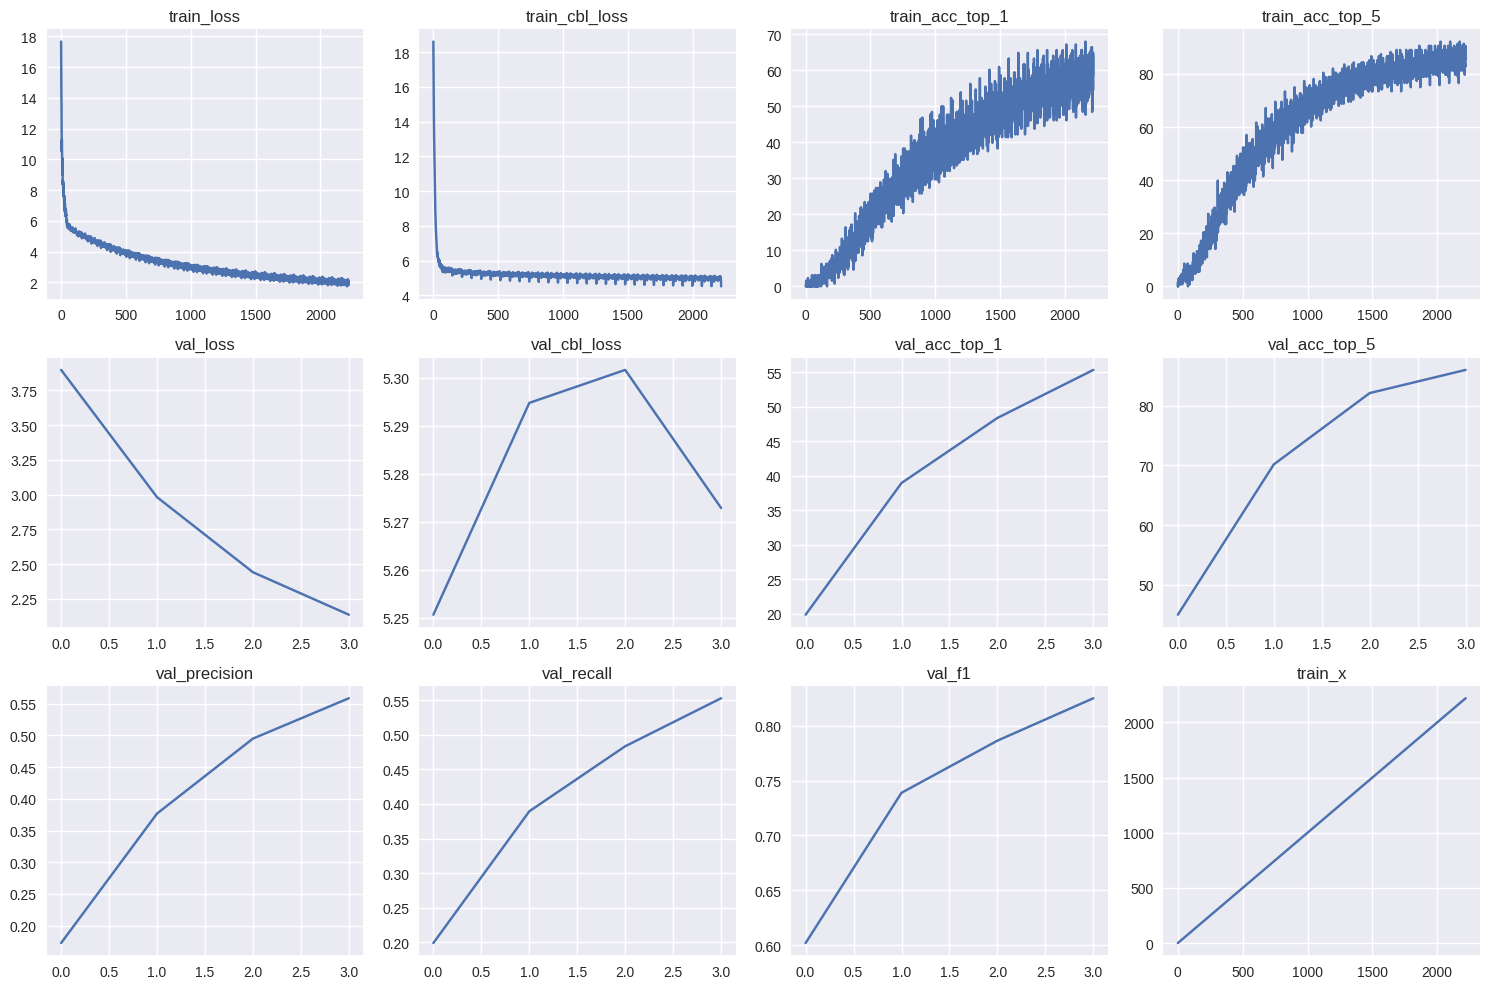

In [46]:
plot_trainer_metrics(trainer.hist)